# Proyecto Final: Análisis de Eficacia "CallMeMaybe"

## Introducción

El servicio de telefonía virtual CallMeMaybe está desarrollando una nueva función que brindará a los supervisores y las supervisores información sobre los operadores menos eficaces. Se considera que un operador es ineficaz si tiene una gran cantidad de llamadas entrantes perdidas (internas y externas) y un tiempo de espera prolongado para las llamadas entrantes. Además, si se supone que un operador debe realizar llamadas salientes, un número reducido de ellas también será un signo de ineficacia.

### Objetivo del proyecto

Identificar a los operadores ineficaces en CallMeMaybe, basado en la cantidad de llamadas entrantes perdidas, el tiempo de espera prolongado y, en caso de operadores asignados a llamadas salientes, el bajo número de estas.


Decisiones que se tomarán con el análisis:

Determinar qué operadores tienen problemas de desempeño.

Posibles ajustes en la distribución de llamadas para mejorar eficiencia.

Evaluar la efectividad de las tarifas y su relación con el desempeño.

Definir estrategias de optimización para reducir la ineficiencia.


Usuarios del análisis:

Supervisores y supervisoras de CallMeMaybe que necesitan información clara sobre el rendimiento de sus operadores.

### Descripción de los datos

El dataset comprimido `telecom_dataset_us.csv` contiene las siguientes columnas:

- `user_id`: ID de la cuenta de cliente
- `date`: fecha en la que se recuperaron las estadísticas
- `direction`: "dirección" de llamada (`out` para saliente, `in` para entrante)
- `internal`: si la llamada fue interna (entre los operadores de un cliente o clienta)
- `operator_id`: identificador del operador
- `is_missed_call`: si fue una llamada perdida
- `calls_count`: número de llamadas
- `call_duration`: duración de la llamada (sin incluir el tiempo de espera)
- `total_call_duration`: duración de la llamada (incluido el tiempo de espera)

 

El conjunto de datos `telecom_clients_us.csv` tiene las siguientes columnas:

- `user_id`: ID de usuario/a
- `tariff_plan`: tarifa actual de la clientela
- `date_start`: fecha de registro de la clientela

## Librerías 

In [284]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr
from scipy.stats import kruskal
from scipy.stats import mannwhitneyu

## Datos

In [285]:
# Carga de los datos
df_calls = pd.read_csv('datasets/telecom_dataset_us.csv')

In [286]:
# Carga de los datos
df_clients = pd.read_csv('datasets/telecom_clients_us.csv')

## Exploración inicial

### df_calls

In [287]:
display(df_calls.head())

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


In [288]:
print(df_calls.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB
None


### df_clients

In [289]:
display(df_clients.head())

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


In [290]:
print(df_clients.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB
None


## Preprocesamiento de Datos

In [291]:
# Convertir user_id a string
df_clients['user_id'] = df_clients['user_id'].astype(str)
df_calls['user_id'] = df_calls['user_id'].astype(str)

In [292]:
# Convertir date_start en clientes a datetime
df_clients['date_start'] = pd.to_datetime(df_clients['date_start'])

In [293]:
# Convertir la columna date a datetime en llamadas
df_calls['date'] = pd.to_datetime(df_calls['date'])

In [294]:
# Crear columnas separadas de fecha y hora
df_calls['call_date'] = pd.to_datetime(df_calls['date'].dt.date)
df_calls['call_time'] = pd.to_datetime(df_calls['date'].dt.strftime('%H:%M:%S'), format='%H:%M:%S')

In [295]:
# Convertir operator_id a string, conservando nulos
df_calls['operator_id'] = df_calls['operator_id'].astype('Int64').astype(str)

In [296]:
# Función para revisar nulos
def revisar_nulos(df, nombre_df):
    print(f"\nNulos en {nombre_df}:")
    nulos = df.isnull().sum()
    porcentaje = (nulos / len(df)) * 100
    resumen = pd.DataFrame({'Nulos': nulos, 'Porcentaje': porcentaje.round(2)})
    print(resumen)

In [297]:
# Revisar nulos en ambos datasets
revisar_nulos(df_clients, "df_clients")
revisar_nulos(df_calls, "df_calls")


Nulos en df_clients:
             Nulos  Porcentaje
user_id          0         0.0
tariff_plan      0         0.0
date_start       0         0.0

Nulos en df_calls:
                     Nulos  Porcentaje
user_id                  0        0.00
date                     0        0.00
direction                0        0.00
internal               117        0.22
operator_id              0        0.00
is_missed_call           0        0.00
calls_count              0        0.00
call_duration            0        0.00
total_call_duration      0        0.00
call_date                0        0.00
call_time                0        0.00


In [298]:
# Reemplazar valores nulos enmascarados por strings
df_calls['operator_id'] = df_calls['operator_id'].replace(['nan', '<NA>'], pd.NA)

In [299]:
# Revisar de nuevo
revisar_nulos(df_calls, "df_calls")


Nulos en df_calls:
                     Nulos  Porcentaje
user_id                  0        0.00
date                     0        0.00
direction                0        0.00
internal               117        0.22
operator_id           8172       15.16
is_missed_call           0        0.00
calls_count              0        0.00
call_duration            0        0.00
total_call_duration      0        0.00
call_date                0        0.00
call_time                0        0.00


In [300]:
# Eliminar registros donde 'internal' es nulo
df_calls = df_calls[df_calls['internal'].notna()]

In [301]:
# Comprobación de limpieza hasta ahora
print(df_calls.info())

<class 'pandas.core.frame.DataFrame'>
Index: 53785 entries, 0 to 53901
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype                    
---  ------               --------------  -----                    
 0   user_id              53785 non-null  object                   
 1   date                 53785 non-null  datetime64[ns, UTC+03:00]
 2   direction            53785 non-null  object                   
 3   internal             53785 non-null  object                   
 4   operator_id          45670 non-null  object                   
 5   is_missed_call       53785 non-null  bool                     
 6   calls_count          53785 non-null  int64                    
 7   call_duration        53785 non-null  int64                    
 8   total_call_duration  53785 non-null  int64                    
 9   call_date            53785 non-null  datetime64[ns]           
 10  call_time            53785 non-null  datetime64[ns]           
dtypes: bool

In [302]:
# Comprobación de limpieza hasta ahora
print(df_clients.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      732 non-null    object        
 1   tariff_plan  732 non-null    object        
 2   date_start   732 non-null    datetime64[ns]
dtypes: datetime64[ns](1), object(2)
memory usage: 17.3+ KB
None


### Exploración de registros sin operator_id

In [303]:
# Filtrar registros con operator_id nulo
nulos_operator = df_calls[df_calls['operator_id'].isna()]

In [304]:
# Distribución de la dirección de llamada
print("Distribución de 'direction' en registros sin operador:")
print(nulos_operator['direction'].value_counts())

Distribución de 'direction' en registros sin operador:
direction
in     7917
out     198
Name: count, dtype: int64


In [305]:
# Internas o no
print("\nDistribución de 'internal':")
print(nulos_operator['internal'].value_counts())


Distribución de 'internal':
internal
False    7760
True      355
Name: count, dtype: int64


In [306]:
# Cantidad de usuarios únicos afectados
print("\nCantidad de usuarios únicos:")
print(nulos_operator['user_id'].nunique())


Cantidad de usuarios únicos:
305


In [307]:
# Primeros registros para inspección
print("\nPrimeros registros con operator_id nulo:")
display(nulos_operator.head())


Primeros registros con operator_id nulo:


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,call_date,call_time
0,166377,2019-08-04 00:00:00+03:00,in,False,<NA>,True,2,0,4,2019-08-04,1900-01-01
7,166377,2019-08-05 00:00:00+03:00,in,False,<NA>,True,6,0,35,2019-08-05,1900-01-01
9,166377,2019-08-06 00:00:00+03:00,in,False,<NA>,True,4,0,62,2019-08-06,1900-01-01
17,166377,2019-08-07 00:00:00+03:00,in,False,<NA>,True,2,0,24,2019-08-07,1900-01-01
27,166377,2019-08-12 00:00:00+03:00,in,False,<NA>,True,2,0,34,2019-08-12,1900-01-01


In [308]:
# Ver distribución de is_missed_call
print("\n¿Fueron llamadas perdidas?")
print(nulos_operator['is_missed_call'].value_counts())


¿Fueron llamadas perdidas?
is_missed_call
True     7993
False     122
Name: count, dtype: int64


In [309]:
# Distribución por fecha (cuántos registros sin operador por día)
nulos_por_fecha = nulos_operator['call_date'].value_counts().sort_index()

In [310]:
print("Top 10 fechas con más operator_id nulos:")
print(nulos_por_fecha.sort_values(ascending=False).head(10))

Top 10 fechas con más operator_id nulos:
call_date
2019-10-28    141
2019-11-20    135
2019-11-25    135
2019-11-28    135
2019-11-26    134
2019-11-19    132
2019-11-14    132
2019-10-25    131
2019-11-07    131
2019-11-12    131
Name: count, dtype: int64


In [311]:
# Crear una copia segura del DataFrame para evitar warnings
nulos_operator = df_calls[df_calls['operator_id'].isna()].copy()

In [312]:
# Obtener la hora de la llamada desde call_time
nulos_operator['call_hour'] = nulos_operator['call_time'].dt.hour
print("\nDistribución por hora (call_time):")
print(nulos_operator['call_hour'].value_counts().sort_index())


Distribución por hora (call_time):
call_hour
0    8115
Name: count, dtype: int64


In [313]:
# Validar la hora desde la columna original 'date'
nulos_operator['original_hour'] = nulos_operator['date'].dt.hour
print("\nDistribución por hora (original_hour):")
print(nulos_operator['original_hour'].value_counts().sort_index())


Distribución por hora (original_hour):
original_hour
0    8115
Name: count, dtype: int64


Exploración y tratamiento de valores nulos.

Durante el preprocesamiento del dataset df_calls, se identificó la presencia de valores nulos en dos columnas: internal (117 registros) y operator_id (8172 registros). Se realizaron análisis exploratorios para comprender su naturaleza y decidir el tratamiento más adecuado en cada caso.

1. internal
Esta columna indica si la llamada fue interna o no. Los 117 registros con valores nulos representan apenas el 0.2% del total y no presentan características particulares relevantes para el análisis general.
 Por ello, se optó por eliminar estos registros, considerándolos como errores de registro o datos incompletos.

2. operator_id
En este caso, el análisis reveló un patrón interesante:

El 98% de los registros con operator_id nulo corresponden a llamadas entrantes, no internas y perdidas.

Estas llamadas representan intentos fallidos de contacto, donde no se llega a establecer conexión con un operador.

Los registros afectados están distribuidos entre más de 300 usuarios distintos, lo que impide una imputación sencilla basada en patrones individuales.

Conclusión:
Dado que los nulos en operator_id reflejan una condición real del negocio (llamadas no atendidas), se decidió conservar estos valores nulos para:

Mantener la fidelidad del dato original.

Realizar análisis diferenciados entre llamadas efectivas y perdidas.

Evitar imputaciones que distorsionen el comportamiento real de los usuarios.

Análisis temporal complementario
Se encontró que los registros con operator_id nulo:

Se concentran en los meses de octubre y noviembre de 2019.

Tienen una hora asignada de 00:00:00, lo cual sugiere:

Que el sistema no almacena la hora real de llamadas perdidas y asigna un valor por defecto.

O que no había operadores disponibles durante la madrugada.

Estos patrones refuerzan la decisión de conservar los nulos y usarlos como un indicador operativo de ineficiencia o saturación

### Exploración de valores duplicados

In [314]:
# Función para revisar duplicados
def revisar_duplicados(df, nombre_df):
    duplicados = df.duplicated().sum()
    print(f"{nombre_df} tiene {duplicados} registros duplicados.")

In [315]:
# Revisar duplicados en ambos datasets
revisar_duplicados(df_clients, "df_clients")
revisar_duplicados(df_calls, "df_calls")

df_clients tiene 0 registros duplicados.


df_calls tiene 4893 registros duplicados.


In [316]:
# Ver duplicados exactos
duplicados_calls = df_calls[df_calls.duplicated(keep=False)]
display(duplicados_calls.sort_values(by='user_id').head())

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,call_date,call_time
6,166377,2019-08-05 00:00:00+03:00,out,False,880020,True,8,0,50,2019-08-05,1900-01-01
417,166377,2019-10-28 00:00:00+03:00,in,False,<NA>,True,2,0,0,2019-10-28,1900-01-01
415,166377,2019-10-28 00:00:00+03:00,out,False,880028,True,9,0,181,2019-10-28,1900-01-01
411,166377,2019-10-28 00:00:00+03:00,in,False,<NA>,True,2,0,0,2019-10-28,1900-01-01
400,166377,2019-10-23 00:00:00+03:00,out,False,880026,True,11,0,298,2019-10-23,1900-01-01


In [317]:
# Usuarios afectados
usuarios_duplicados = duplicados_calls['user_id'].nunique()
print(f"\nUsuarios únicos con duplicados: {usuarios_duplicados}")


Usuarios únicos con duplicados: 269


In [318]:
# Eliminar duplicados exactos considerando todas las columnas
df_calls = df_calls.drop_duplicates()

In [319]:
# Verificación final
print(f"\nShape del dataset final sin duplicados: {df_calls.shape}")


Shape del dataset final sin duplicados: (48892, 11)


Tratamiento de registros duplicados en df_calls
Durante el preprocesamiento se identificaron 4,893 registros duplicados exactos en el dataset de llamadas (df_calls). Estos duplicados representan copias idénticas de registros ya existentes, sin diferencias en ninguna de las columnas.

Decisión tomada:

Se aplicó drop_duplicates() considerando todas las columnas para eliminar estos registros, ya que:

No aportan información nueva, solo repiten datos ya presentes.

Inflan artificialmente conteos y promedios.

Su eliminación mejora la precisión y confiabilidad de los análisis posteriores.

### Estado final de los datos 

In [320]:
print(df_clients.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      732 non-null    object        
 1   tariff_plan  732 non-null    object        
 2   date_start   732 non-null    datetime64[ns]
dtypes: datetime64[ns](1), object(2)
memory usage: 17.3+ KB
None


In [321]:
print(df_calls.info())

<class 'pandas.core.frame.DataFrame'>
Index: 48892 entries, 0 to 53901
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype                    
---  ------               --------------  -----                    
 0   user_id              48892 non-null  object                   
 1   date                 48892 non-null  datetime64[ns, UTC+03:00]
 2   direction            48892 non-null  object                   
 3   internal             48892 non-null  object                   
 4   operator_id          41491 non-null  object                   
 5   is_missed_call       48892 non-null  bool                     
 6   calls_count          48892 non-null  int64                    
 7   call_duration        48892 non-null  int64                    
 8   total_call_duration  48892 non-null  int64                    
 9   call_date            48892 non-null  datetime64[ns]           
 10  call_time            48892 non-null  datetime64[ns]           
dtypes: bool

## EDA

### Análisis exploratorio de call_duration
Esta columna indica la duración efectiva de la llamada (sin contar el tiempo de espera).
Se sospecha que algunas llamadas duran demasiado, lo cual puede indicar problemas operativos como:

Operadores que olvidan colgar.

Sistemas que no registran el fin correcto de la llamada.

Se explorará la distribución de esta variable para detectar outliers, y posteriormente se analizarán sus características.

In [322]:
# Estadísticas descriptivas
print("Estadísticas de call_duration:")
display(df_calls['call_duration'].describe())

Estadísticas de call_duration:


count     48892.000000
mean        868.088788
std        3779.549967
min           0.000000
25%           0.000000
50%          37.000000
75%         573.000000
max      144395.000000
Name: call_duration, dtype: float64

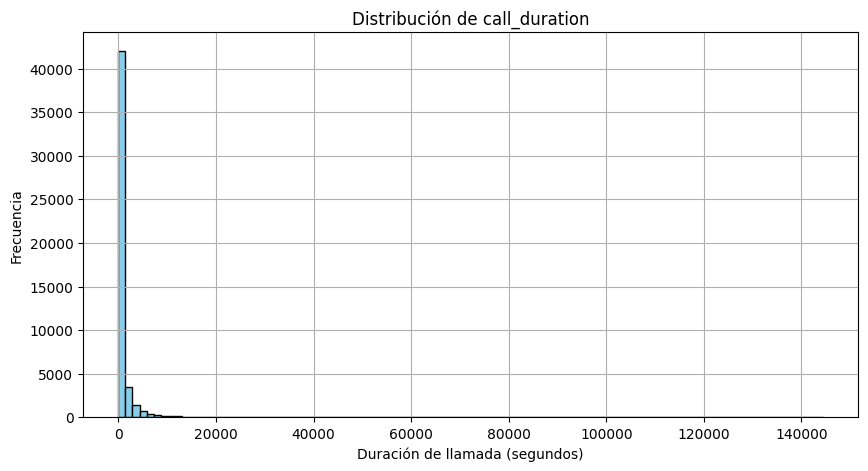

In [323]:
# Histograma general
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.hist(df_calls['call_duration'], bins=100, color='skyblue', edgecolor='black')
plt.title('Distribución de call_duration')
plt.xlabel('Duración de llamada (segundos)')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

 Identificación de outliers extremos en call_duration
Se utilizará el método del rango intercuartílico (IQR) para identificar llamadas cuya duración es excesivamente alta y no representativa del comportamiento típico.

In [324]:
# Cálculo de límites usando IQR
q1 = df_calls['call_duration'].quantile(0.25)
q3 = df_calls['call_duration'].quantile(0.75)
iqr = q3 - q1

# Definimos límite superior para detectar outliers
limite_superior = q3 + 1.5 * iqr

print(f"Límite superior para outliers: {limite_superior:.2f} segundos")

Límite superior para outliers: 1432.50 segundos


In [325]:
# Filtrar registros outliers
df_outliers = df_calls[df_calls['call_duration'] > limite_superior]
print(f"Número de registros outliers: {len(df_outliers)}")

Número de registros outliers: 6846


In [326]:
# Ver distribución de dirección, si fue perdida, etc.
print("\nDistribución de 'direction':")
print(df_outliers['direction'].value_counts())


Distribución de 'direction':
direction
out    4974
in     1872
Name: count, dtype: int64


In [327]:
print("\n¿Fue llamada perdida?")
print(df_outliers['is_missed_call'].value_counts())


¿Fue llamada perdida?
is_missed_call
False    6846
Name: count, dtype: int64


In [328]:
print("\n¿Interna?")
print(df_outliers['internal'].value_counts())


¿Interna?
internal
False    6816
True       30
Name: count, dtype: int64


In [329]:
# Mostrar algunos registros para inspección
display(df_outliers.sort_values(by='call_duration', ascending=False).head())

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,call_date,call_time
6946,166582,2019-09-25 00:00:00+03:00,out,False,885876,False,1230,144395,166155,2019-09-25,1900-01-01
6950,166582,2019-09-26 00:00:00+03:00,out,False,885876,False,843,132206,146903,2019-09-26,1900-01-01
6833,166582,2019-09-12 00:00:00+03:00,out,False,885876,False,696,125286,138643,2019-09-12,1900-01-01
6889,166582,2019-09-18 00:00:00+03:00,out,False,885876,False,1013,121664,140050,2019-09-18,1900-01-01
6808,166582,2019-09-09 00:00:00+03:00,out,False,885876,False,1138,121093,141930,2019-09-09,1900-01-01


Observaciones clave de los outliers en call_duration.
Hallazgos relevantes sobre llamadas con duración anómala
Se identificaron 6,846 registros outliers cuya duración supera los 1,432.5 segundos (~24 minutos).

Estos valores representan el 14% del total y están fuertemente sesgados hacia duraciones extremadamente largas (hasta 40 horas).

Patrones observados:

100% de las llamadas outliers fueron efectivas, es decir, no fueron perdidas (is_missed_call = False).

La mayoría fueron llamadas salientes (direction = out), y en su gran mayoría, no internas.

Se detectaron casos extremos donde un solo operador (885876) aparece repetidamente en los registros más largos, sugiriendo comportamiento fuera de norma o mal uso del sistema (por ejemplo, llamadas abiertas indefinidamente).

Conclusión inicial:
Este tipo de registros son indicio claro de posibles malas prácticas, ineficiencia o errores del sistema.
Serán excluidos de los análisis generales para evitar distorsión de métricas, pero se conservarán en un dataset aparte para seguimiento o revisión puntual de operadores con desempeño crítico.

In [330]:
# Contar cuántos operadores están presentes en los outliers
operadores_outliers = df_outliers['operator_id'].nunique()
print(f"Número de operadores únicos con llamadas outliers: {operadores_outliers}")

Número de operadores únicos con llamadas outliers: 519


In [331]:
# Top operadores con más outliers
print("\nTop operadores con más llamadas outliers:")
display(df_outliers['operator_id'].value_counts().head(20))


Top operadores con más llamadas outliers:


operator_id
901880    135
890406    102
885890     99
885876     98
891410     97
890404     93
893804     92
890402     92
882686     87
901884     84
891414     78
921318     70
879898     65
880026     61
931458     60
882684     59
891154     57
913938     57
880028     55
890412     54
Name: count, dtype: int64

In [332]:
# Operadores únicos en todo el dataset
total_operadores = df_calls['operator_id'].nunique()

# Operadores con al menos una llamada outlier ya lo tenemos: 519
porcentaje_outliers = (operadores_outliers / total_operadores) * 100

print(f"Total de operadores únicos: {total_operadores}")
print(f"Proporción con al menos una llamada outlier: {porcentaje_outliers:.2f}%")

Total de operadores únicos: 1092
Proporción con al menos una llamada outlier: 47.53%


Observaciones finales sobre los outliers en call_duration:

Se identificaron 6,846 llamadas outliers con duraciones superiores a 1,432.5 segundos (~24 minutos), representando alrededor del 14% del total de llamadas.

Lo más relevante es que estos registros no están concentrados en unos cuantos casos, sino que:

519 operadores distintos presentan al menos una llamada outlier.

Esto equivale al 47.5% del total de operadores, lo que indica una distribución ampliamente extendida de este tipo de anomalías.

La mayoría de estas llamadas son:

Salientes

No internas

Efectivas (no perdidas)

Con duraciones altamente variables, desde apenas fuera del umbral hasta más de 144,000 segundos (~40 horas).

Conclusión operativa:

Estas llamadas indican potenciales malas prácticas, falta de seguimiento o fallas en el cierre de llamadas.

Este subconjunto de operadores constituye un primer grupo con indicios de ineficiencia que podría requerir intervención operativa.

Se conservarán estos registros para análisis específicos, pero se excluyen del análisis principal a través de la creación de un dataset limpio sin outliers: df_calls_no_outliers.

In [333]:
# Crear copia del dataset sin los outliers de call_duration
df_calls_no_outliers = df_calls[df_calls['call_duration'] <= limite_superior].copy()

print(f"Shape del dataset limpio para análisis: {df_calls_no_outliers.shape}")

Shape del dataset limpio para análisis: (42046, 11)


In [334]:
print(df_calls_no_outliers.info())

<class 'pandas.core.frame.DataFrame'>
Index: 42046 entries, 0 to 53901
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype                    
---  ------               --------------  -----                    
 0   user_id              42046 non-null  object                   
 1   date                 42046 non-null  datetime64[ns, UTC+03:00]
 2   direction            42046 non-null  object                   
 3   internal             42046 non-null  object                   
 4   operator_id          34699 non-null  object                   
 5   is_missed_call       42046 non-null  bool                     
 6   calls_count          42046 non-null  int64                    
 7   call_duration        42046 non-null  int64                    
 8   total_call_duration  42046 non-null  int64                    
 9   call_date            42046 non-null  datetime64[ns]           
 10  call_time            42046 non-null  datetime64[ns]           
dtypes: bool

### Análsisi exploratorio sin outliers en la columna de call_duration

In [335]:
# Crear columna wait_time
df_calls_no_outliers['wait_time'] = df_calls_no_outliers['total_call_duration'] - df_calls_no_outliers['call_duration']

# Validar que no haya negativos
print("¿Hay valores negativos en wait_time?:", (df_calls_no_outliers['wait_time'] < 0).sum())

# Vista rápida
display(df_calls_no_outliers[['call_duration', 'total_call_duration', 'wait_time']].head())

¿Hay valores negativos en wait_time?: 0


,call_duration,total_call_duration,wait_time
0,0,4,4
1,0,5,5
2,0,1,1
3,10,18,8
4,0,25,25


Métricas por operador:

Se agruparán los datos por operator_id para calcular:

Total de llamadas entrantes perdidas.

Promedio de tiempo de espera (wait_time) en llamadas entrantes.

Total de llamadas salientes realizadas (si aplica).

Estas métricas permitirán detectar operadores con bajo desempeño, de acuerdo con la definición planteada en el objetivo del proyecto.

In [336]:
# Agrupación por operador
df_operadores = df_calls_no_outliers.groupby('operator_id').agg(

    llamadas_entrantes_perdidas = ('is_missed_call', lambda x: ((x) & (df_calls_no_outliers['direction'] == 'in')).sum()),
    promedio_espera = ('wait_time', lambda x: x[df_calls_no_outliers['direction'] == 'in'].mean()),
    llamadas_salientes = ('calls_count', lambda x: x[df_calls_no_outliers['direction'] == 'out'].sum()),
    total_llamadas = ('calls_count', 'sum')
).reset_index()

# Vista rápida
display(df_operadores.head(15))

,operator_id,llamadas_entrantes_perdidas,promedio_espera,llamadas_salientes,total_llamadas
0,879896,0,27.333333,419,477
1,879898,0,29.875000,2554,2657
2,880020,0,7.714286,38,45
3,880022,0,14.000000,186,194
4,880026,0,7.944444,838,862
5,880028,0,8.365854,1286,1349
6,880240,0,NaN,24,24
7,881278,0,NaN,20,20
8,882476,0,31.666667,0,3
9,882478,0,38.000000,1,4


C:\Users\joako\AppData\Local\Temp\ipykernel_18300\1660563028.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_missed, x='operator_id', y='llamadas_entrantes_perdidas', palette='Reds_r')
C:\Users\joako\AppData\Local\Temp\ipykernel_18300\1660563028.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_wait, x='operator_id', y='promedio_espera', palette='Oranges')
C:\Users\joako\AppData\Local\Temp\ipykernel_18300\1660563028.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bottom_out, x='operator_id', y='llamadas_sal

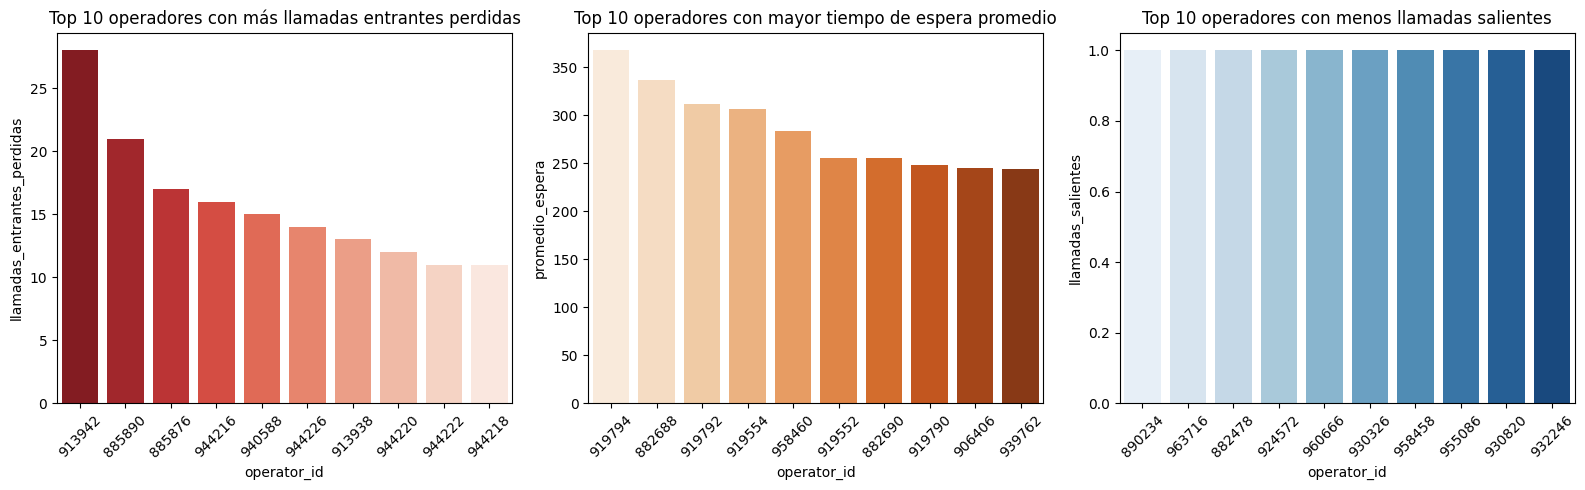

In [337]:
# Configuración de estilo
plt.figure(figsize=(16, 5))

# Subplot 1: Llamadas entrantes perdidas
plt.subplot(1, 3, 1)
top_missed = df_operadores.sort_values(by='llamadas_entrantes_perdidas', ascending=False).head(10)
sns.barplot(data=top_missed, x='operator_id', y='llamadas_entrantes_perdidas', palette='Reds_r')
plt.title('Top 10 operadores con más llamadas entrantes perdidas')
plt.xticks(rotation=45)

# Subplot 2: Promedio de espera más alto
plt.subplot(1, 3, 2)
top_wait = df_operadores.sort_values(by='promedio_espera', ascending=False).head(10)
sns.barplot(data=top_wait, x='operator_id', y='promedio_espera', palette='Oranges')
plt.title('Top 10 operadores con mayor tiempo de espera promedio')
plt.xticks(rotation=45)

# Subplot 3: Llamadas salientes más bajas (pero con llamadas)
plt.subplot(1, 3, 3)
salientes_filtrados = df_operadores[df_operadores['llamadas_salientes'] > 0]
bottom_out = salientes_filtrados.sort_values(by='llamadas_salientes').head(10)
sns.barplot(data=bottom_out, x='operator_id', y='llamadas_salientes', palette='Blues')
plt.title('Top 10 operadores con menos llamadas salientes')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [338]:
# Definir condiciones de ineficiencia
condicion_1 = df_operadores['llamadas_entrantes_perdidas'] > 0
condicion_2 = df_operadores['promedio_espera'] > 60
condicion_3 = (df_operadores['llamadas_salientes'] > 0) & (df_operadores['llamadas_salientes'] < 10)

# Crear columna de evaluación
df_operadores['ineficiente'] = condicion_1 | condicion_2 | condicion_3

# Filtrar solo los operadores ineficientes
ranking_ineficientes = df_operadores[df_operadores['ineficiente']].copy()

# Ordenar por múltiples criterios para priorizar casos más graves
ranking_ineficientes = ranking_ineficientes.sort_values(
    by=['llamadas_entrantes_perdidas', 'promedio_espera', 'llamadas_salientes'],
    ascending=[False, False, True]
)


In [339]:
display(ranking_ineficientes.head(20))

,operator_id,llamadas_entrantes_perdidas,promedio_espera,llamadas_salientes,total_llamadas,ineficiente
368,913942,28,48.923077,440,602,True
29,885890,21,92.972973,23781,24513,True
28,885876,17,78.762500,23349,24050,True
818,944216,16,144.086957,119,301,True
778,940588,15,13.321429,67,155,True
822,944226,14,131.608696,109,262,True
367,913938,13,36.409091,371,463,True
820,944220,12,183.581395,211,430,True
464,919554,11,306.230769,8,376,True
819,944218,11,157.487179,164,326,True


In [340]:
# Número de operadores por grupo
conteo = ranking_ineficientes['ineficiente'].value_counts()
print("Distribución de operadores:")
print(conteo)

Distribución de operadores:
ineficiente
True    479
Name: count, dtype: int64


In [341]:
# Agrupación por eficiencia para resumen estadístico
resumen_metricas = df_operadores.groupby('ineficiente')[['llamadas_entrantes_perdidas', 'promedio_espera', 'llamadas_salientes', 'total_llamadas']].mean().round(2)
resumen_metricas.index = ['Eficientes', 'Ineficientes']
display(resumen_metricas)

,llamadas_entrantes_perdidas,promedio_espera,llamadas_salientes,total_llamadas
Eficientes,0.00,25.35,323.24,337.87
Ineficientes,1.43,56.96,281.10,345.34


In [342]:
# Total de operadores en el análisis
total_operadores = df_operadores.shape[0]

# Conteo por grupo
conteo_grupos = df_operadores['ineficiente'].value_counts()
ineficientes = conteo_grupos[True]
eficientes = conteo_grupos[False]

# Cálculo de proporciones
proporcion_ineficientes = (ineficientes / total_operadores) * 100
proporcion_eficientes = (eficientes / total_operadores) * 100

# Resultados
print(f"Total de operadores: {total_operadores}")
print(f"Operadores ineficientes: {ineficientes} ({proporcion_ineficientes:.2f}%)")
print(f"Operadores eficientes: {eficientes} ({proporcion_eficientes:.2f}%)")

Total de operadores: 1090
Operadores ineficientes: 479 (43.94%)
Operadores eficientes: 611 (56.06%)


Comparativa de desempeño: operadores eficientes vs. ineficientes:

Para evaluar la magnitud del problema de ineficiencia, se realizó una segmentación de operadores basada en los siguientes criterios:

Tener al menos una llamada entrante perdida.

Tener un tiempo promedio de espera superior a 60 segundos.

Tener menos de 10 llamadas salientes realizadas (si es que se espera que hagan llamadas salientes).

Resultados de la segmentación:

Total de operadores analizados: 1,090

Operadores ineficientes: 479 (43.94%)

Operadores eficientes: 611 (56.06%)


Los operadores identificados como ineficientes muestran, en promedio, mayores tiempos de espera, más llamadas perdidas y menos llamadas salientes, lo que valida el criterio de clasificación aplicado y justifica su análisis diferenciado en fases posteriores.

Cruce con información de tarifas
Se busca analizar si existe relación entre el desempeño de los operadores y el plan tarifario del cliente (tariff_plan) al que pertenecen.

Para ello se integrará el dataset df_clients con las métricas por operador, utilizando el campo user_id como llave de unión.

Nota técnica:
Como la información de operator_id no está directamente en df_clients, primero se hará el cruce entre df_calls_no_outliers y df_clients, y luego se volverá a agrupar por operator_id.

In [343]:
# Cruce entre llamadas y datos de clientes
df_merged = df_calls_no_outliers.merge(df_clients, on='user_id', how='left')

# Validación rápida
print("Columnas después del merge:", df_merged.columns.tolist())
print("Tarifas únicas:", df_merged['tariff_plan'].unique())
display(df_merged.head())

Columnas después del merge: ['user_id', 'date', 'direction', 'internal', 'operator_id', 'is_missed_call', 'calls_count', 'call_duration', 'total_call_duration', 'call_date', 'call_time', 'wait_time', 'tariff_plan', 'date_start']
Tarifas únicas: ['B' 'C' 'A']


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,call_date,call_time,wait_time,tariff_plan,date_start
0,166377,2019-08-04 00:00:00+03:00,in,False,<NA>,True,2,0,4,2019-08-04,1900-01-01,4,B,2019-08-01
1,166377,2019-08-05 00:00:00+03:00,out,True,880022,True,3,0,5,2019-08-05,1900-01-01,5,B,2019-08-01
2,166377,2019-08-05 00:00:00+03:00,out,True,880020,True,1,0,1,2019-08-05,1900-01-01,1,B,2019-08-01
3,166377,2019-08-05 00:00:00+03:00,out,True,880020,False,1,10,18,2019-08-05,1900-01-01,8,B,2019-08-01
4,166377,2019-08-05 00:00:00+03:00,out,False,880022,True,3,0,25,2019-08-05,1900-01-01,25,B,2019-08-01


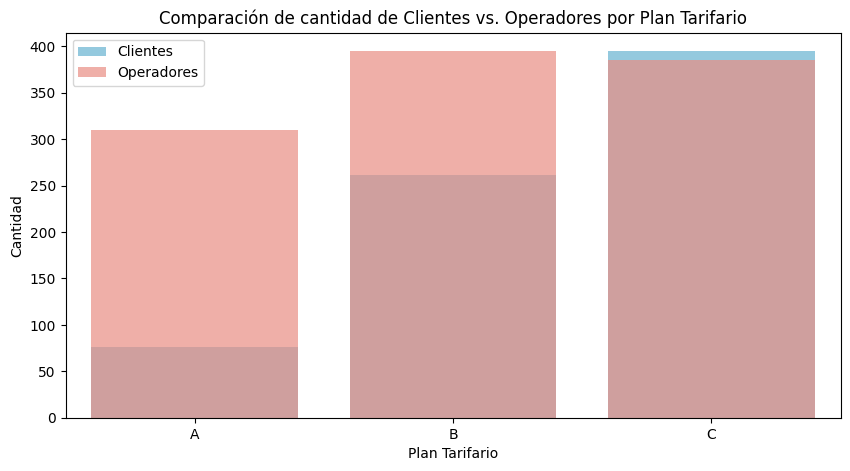

In [344]:
# Clientes por plan
clientes_por_plan = df_clients['tariff_plan'].value_counts().sort_index()

# Operadores únicos por plan
operadores_por_plan = df_merged.groupby('tariff_plan')['operator_id'].nunique().sort_index()

# Gráfico comparativo
plt.figure(figsize=(10, 5))
sns.barplot(x=clientes_por_plan.index, y=clientes_por_plan.values, color='skyblue', label='Clientes')
sns.barplot(x=operadores_por_plan.index, y=operadores_por_plan.values, color='salmon', label='Operadores', alpha=0.7)

plt.title("Comparación de cantidad de Clientes vs. Operadores por Plan Tarifario")
plt.ylabel("Cantidad")
plt.xlabel("Plan Tarifario")
plt.legend()
plt.show()

Observaciones: distribución de clientes vs. operadores por plan:

El gráfico revela un posible desbalance en la asignación de operadores respecto al número de clientes por plan tarifario:

Plan C tiene más clientes que operadores, lo cual podría generar sobrecarga operativa y, por ende, mayor probabilidad de ineficiencia.

Planes A y B, en cambio, presentan una mayor cantidad de operadores en relación con sus clientes, lo cual sugiere una mejor distribución o incluso una subutilización de recursos.

Posible insight inicial:

Reubicar o redistribuir operadores de planes A o B hacia el plan C podría equilibrar la carga operativa y mejorar el desempeño global.

Sin embargo, es necesario complementar este análisis observando el volumen de llamadas que realiza cada grupo de clientes, ya que un mayor número de clientes no necesariamente implica mayor demanda operativa.

Carga operativa por plan tarifario:

Para evaluar si el número de clientes en cada plan está relacionado con un mayor uso del servicio, se analizará el número total de llamadas generadas por los clientes de cada plan tarifario (tariff_plan).

Esto permitirá entender si el desbalance detectado entre clientes y operadores también representa una sobrecarga real de llamadas para ciertos planes.

C:\Users\joako\AppData\Local\Temp\ipykernel_18300\1584298601.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=llamadas_por_plan.index, y=llamadas_por_plan.values, palette='viridis')


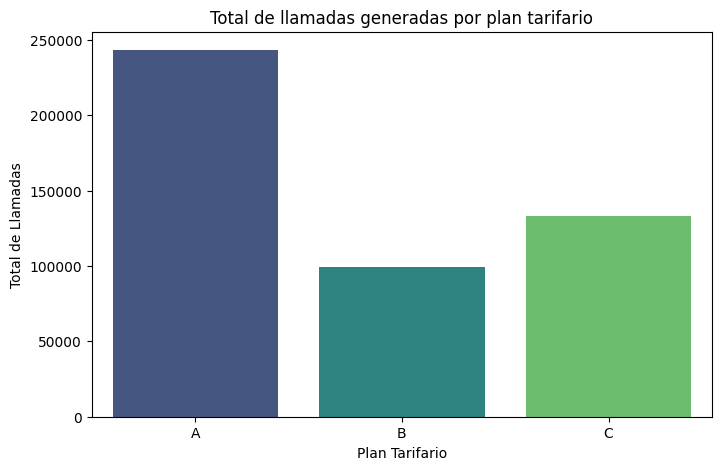

In [345]:
# Sumar número total de llamadas (calls_count) por plan tarifario
llamadas_por_plan = df_merged.groupby('tariff_plan')['calls_count'].sum().sort_index()

# Visualización
plt.figure(figsize=(8, 5))
sns.barplot(x=llamadas_por_plan.index, y=llamadas_por_plan.values, palette='viridis')

plt.title("Total de llamadas generadas por plan tarifario")
plt.xlabel("Plan Tarifario")
plt.ylabel("Total de Llamadas")
plt.show()

El análisis del volumen de llamadas revela que el Plan A, a pesar de tener menos clientes que el Plan C, genera por mucho el mayor número de llamadas:

Plan A: ~240,000 llamadas

Plan B: ~100,000 llamadas

Plan C: ~135,000 llamadas

Implicaciones:

El Plan A representa la mayor carga operativa para los operadores.

Redistribuir personal al Plan C podría no ser suficiente o incluso contraproducente, ya que el verdadero cuello de botella parece estar en el Plan A.

Es recomendable investigar si el Plan A tiene características, fallas o condiciones que generen mayor necesidad de contacto, ya que esto puede ser un foco de insatisfacción o ineficiencia estructural.

Promedio de llamadas por operador por día según plan tarifario:

Para hacerlo vamos a:

Calcular el número total de llamadas por tariff_plan y call_date (o date).

Calcular el número de operadores únicos activos por plan por día.

Dividir llamadas entre operadores para tener el promedio de carga diaria por operador.

C:\Users\joako\AppData\Local\Temp\ipykernel_18300\223687388.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=promedios_por_plan.index, y=promedios_por_plan.values, palette='magma')


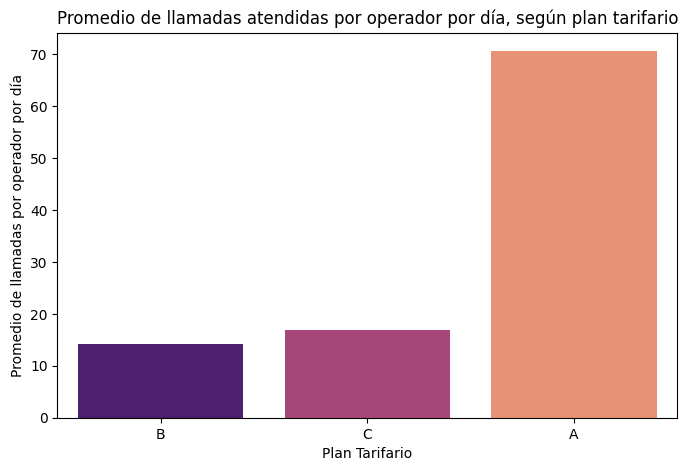

In [346]:
# Recalcular incluyendo un filtro para evitar divisiones por cero
llamadas_por_dia_plan = df_merged.groupby(['call_date', 'tariff_plan']).agg({
    'calls_count': 'sum',
    'operator_id': pd.Series.nunique
}).rename(columns={'calls_count': 'total_llamadas', 'operator_id': 'operadores_activos'}).reset_index()

# Filtrar registros donde no hubo operadores activos (para evitar división por cero)
llamadas_por_dia_plan = llamadas_por_dia_plan[llamadas_por_dia_plan['operadores_activos'] > 0]

# Calcular llamadas promedio por operador por día
llamadas_por_dia_plan['llamadas_por_operador'] = llamadas_por_dia_plan['total_llamadas'] / llamadas_por_dia_plan['operadores_activos']

# Promedio general por plan
promedios_por_plan = llamadas_por_dia_plan.groupby('tariff_plan')['llamadas_por_operador'].mean().sort_values()

# Graficar
plt.figure(figsize=(8, 5))
sns.barplot(x=promedios_por_plan.index, y=promedios_por_plan.values, palette='magma')

plt.title("Promedio de llamadas atendidas por operador por día, según plan tarifario")
plt.xlabel("Plan Tarifario")
plt.ylabel("Promedio de llamadas por operador por día")
plt.show()

Insight importante:

Plan A: Más de 70 llamadas diarias por operador, en promedio. Esto es muchísimo. Es probable que:

Haya más usuarios demandando soporte (como ya vimos).

No haya suficientes operadores asignados.

Estén ocurriendo muchas llamadas de seguimiento (es decir, que no se resuelve a la primera).

Planes B y C: En el rango de 15 a 17 llamadas por operador por día, mucho más sostenible.

Posibles decisiones a partir de este hallazgo:
Redistribuir operadores: trasladar parte de la fuerza laboral de planes B y C hacia A.

Reevaluar el plan A: ¿qué está generando tanta fricción? Tal vez no está claro su uso, no hay autoservicio, o es un perfil de cliente más demandante.

Automatización o mejora de procesos en Plan A: chatbots, FAQs, o más operadores especializados.

In [347]:
# Merge entre df_outliers y df_clients para agregar plan tarifario
df_outliers_merged = df_outliers.merge(df_clients, on='user_id', how='left')

# Verificar columnas y valores únicos de tarifa
print("Tarifas únicas entre los outliers:", df_outliers_merged['tariff_plan'].unique())
display(df_outliers_merged.head())

Tarifas únicas entre los outliers: ['B' 'A' 'C']


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,call_date,call_time,tariff_plan,date_start
0,166377,2019-08-09 00:00:00+03:00,out,False,880028,False,17,1603,1725,2019-08-09,1900-01-01,B,2019-08-01
1,166377,2019-08-12 00:00:00+03:00,out,False,880028,False,20,2074,2191,2019-08-12,1900-01-01,B,2019-08-01
2,166377,2019-08-14 00:00:00+03:00,out,False,880028,False,18,2686,2782,2019-08-14,1900-01-01,B,2019-08-01
3,166377,2019-08-14 00:00:00+03:00,out,False,880026,False,10,1567,1654,2019-08-14,1900-01-01,B,2019-08-01
4,166377,2019-08-15 00:00:00+03:00,out,False,880028,False,19,2653,2779,2019-08-15,1900-01-01,B,2019-08-01


In [348]:
# Conteo de outliers por plan
conteo_outliers_tarifa = df_outliers_merged['tariff_plan'].value_counts().sort_index()

# Proporción de outliers por plan
proporcion_outliers_tarifa = (conteo_outliers_tarifa / len(df_outliers_merged) * 100).round(2)

# Unir ambos en un DataFrame para vista ordenada
resumen_outliers = pd.DataFrame({
    'Cantidad de Outliers': conteo_outliers_tarifa,
    'Proporción (%)': proporcion_outliers_tarifa
})

display(resumen_outliers)

,Cantidad de Outliers,Proporción (%)
tariff_plan,,
A,2276,33.25
B,2391,34.93
C,2179,31.83


C:\Users\joako\AppData\Local\Temp\ipykernel_18300\1113555983.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


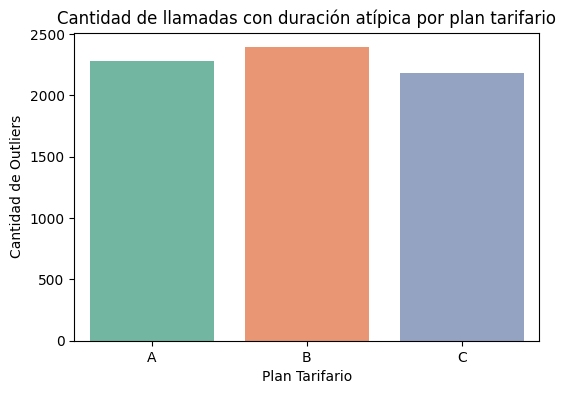

In [349]:
# Gráfico
plt.figure(figsize=(6, 4))
sns.barplot(
    x=resumen_outliers.index,
    y=resumen_outliers['Cantidad de Outliers'],
    palette='Set2'
)
plt.title("Cantidad de llamadas con duración atípica por plan tarifario")
plt.xlabel("Plan Tarifario")
plt.ylabel("Cantidad de Outliers")
plt.show()

 A pesar de que el plan B tiene ligeramente más llamadas atípicas (outliers), las proporciones entre los tres planes están bastante balanceadas:

Plan B: 34.93%

Plan A: 33.25%

Plan C: 31.83%

¿Qué implica esto?
Parece que las llamadas de duración inusualmente alta no están concentradas en un solo plan, lo que sugiere que el fenómeno es transversal y probablemente está relacionado con comportamientos de ciertos operadores o problemas en el sistema (por ejemplo, colgar llamadas, errores de logging, o clientes con casos complejos), más que con un tipo específico de plan tarifario.

Podemos concluir que:

No hay evidencia clara de que algún plan tarifario esté causando más llamadas atípicas.

El enfoque de mejora podría centrarse en revisar a los operadores con más casos de outliers, sin importar el plan.

También sería útil ver si ciertos usuarios o franjas horarias concentran estas llamadas, por si hay algún patrón operativo detrás

### Distribución de llamadas por operador:

Cuántas llamadas entrantes, salientes e internas realiza cada operador.

Cuántas llamadas se pierden en promedio por operador.

Cuál es la distribución de duración de llamadas y tiempos de espera.

In [350]:
# Agrupar por operador y calcular métricas clave
df_operador_llamadas = df_calls_no_outliers.groupby('operator_id').agg({
    'direction': lambda x: (x == 'in').sum(),        # Llamadas entrantes
    'internal': lambda x: (x == 'True').sum(),       # Llamadas internas
    'is_missed_call': 'mean',                        # Promedio de llamadas perdidas
    'call_duration': 'mean',                         # Duración promedio
    'wait_time': 'mean'                              # Tiempo de espera promedio
}).rename(columns={
    'direction': 'llamadas_entrantes',
    'internal': 'llamadas_internas',
    'is_missed_call': 'promedio_llamadas_perdidas',
    'call_duration': 'duracion_promedio',
    'wait_time': 'espera_promedio'
})

# Calcular llamadas salientes (total - entrantes)
df_operador_llamadas['llamadas_salientes'] = df_calls_no_outliers.groupby('operator_id').size() - df_operador_llamadas['llamadas_entrantes']

# Ordenar por operador
df_operador_llamadas = df_operador_llamadas.reset_index().sort_values(by='operator_id')

# Mostrar resultado
display(df_operador_llamadas.head(15))

,operator_id,llamadas_entrantes,llamadas_internas,promedio_llamadas_perdidas,duracion_promedio,espera_promedio,llamadas_salientes
0,879896,21,0,0.443396,177.094340,78.509434,85
1,879898,56,0,0.552795,88.627329,334.111801,105
2,880020,7,0,0.300000,112.250000,14.000000,13
3,880022,8,0,0.420290,184.579710,54.637681,61
4,880026,18,0,0.719008,138.570248,113.140496,103
5,880028,41,0,0.557823,177.925170,216.782313,106
6,880240,0,0,0.636364,86.454545,33.818182,11
7,881278,0,0,0.875000,58.125000,9.750000,8
8,882476,3,0,0.000000,64.000000,31.666667,0
9,882478,2,0,0.333333,22.666667,27.666667,1


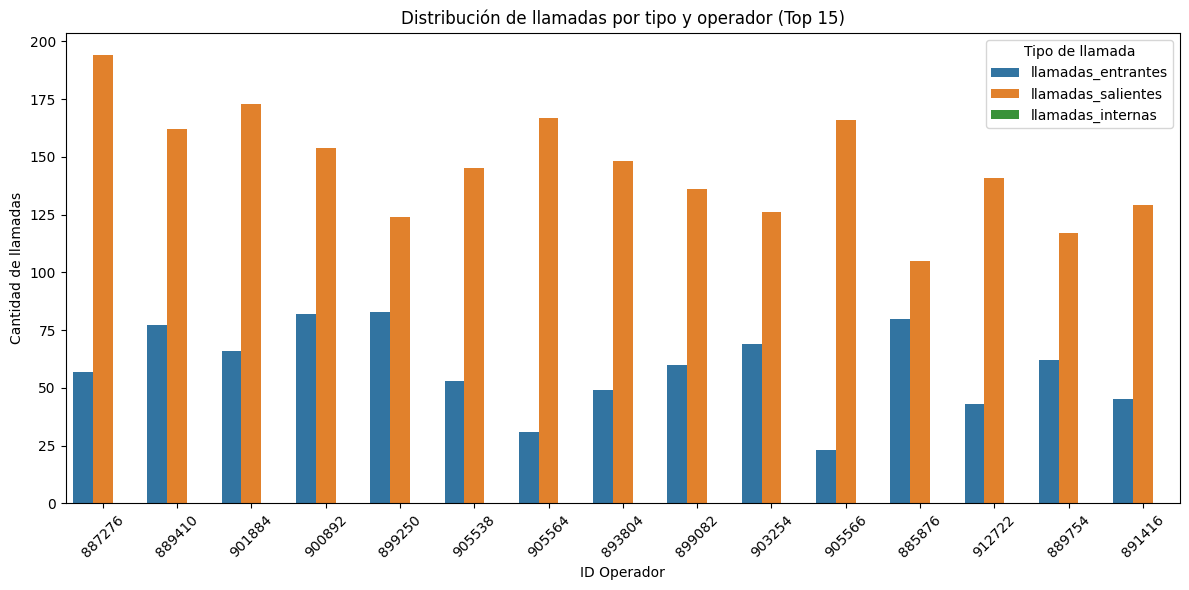

In [351]:
# Crear columna con total de llamadas sumando los tres tipos
df_operador_llamadas['total_llamadas'] = (
    df_operador_llamadas['llamadas_entrantes'] +
    df_operador_llamadas['llamadas_salientes'] +
    df_operador_llamadas['llamadas_internas']
)

# Seleccionar top 15 operadores con más llamadas
top_operadores = df_operador_llamadas.nlargest(15, 'total_llamadas')

# Reformatear a formato long para graficar más fácil
df_long = top_operadores.melt(
    id_vars='operator_id',
    value_vars=['llamadas_entrantes', 'llamadas_salientes', 'llamadas_internas'],
    var_name='tipo_llamada',
    value_name='cantidad'
)

# Gráfico
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.barplot(data=df_long, x='operator_id', y='cantidad', hue='tipo_llamada')

plt.title('Distribución de llamadas por tipo y operador (Top 15)')
plt.xlabel('ID Operador')
plt.ylabel('Cantidad de llamadas')
plt.xticks(rotation=45)
plt.legend(title='Tipo de llamada')
plt.tight_layout()
plt.show()

Observaciones preliminares:

Se confirma que la mayoría de los operadores están gestionando principalmente llamadas salientes.

Las llamadas entrantes también tienen presencia, pero en menor cantidad.

Y las llamadas internas son prácticamente nulas o inexistentes para estos top 15 operadores.

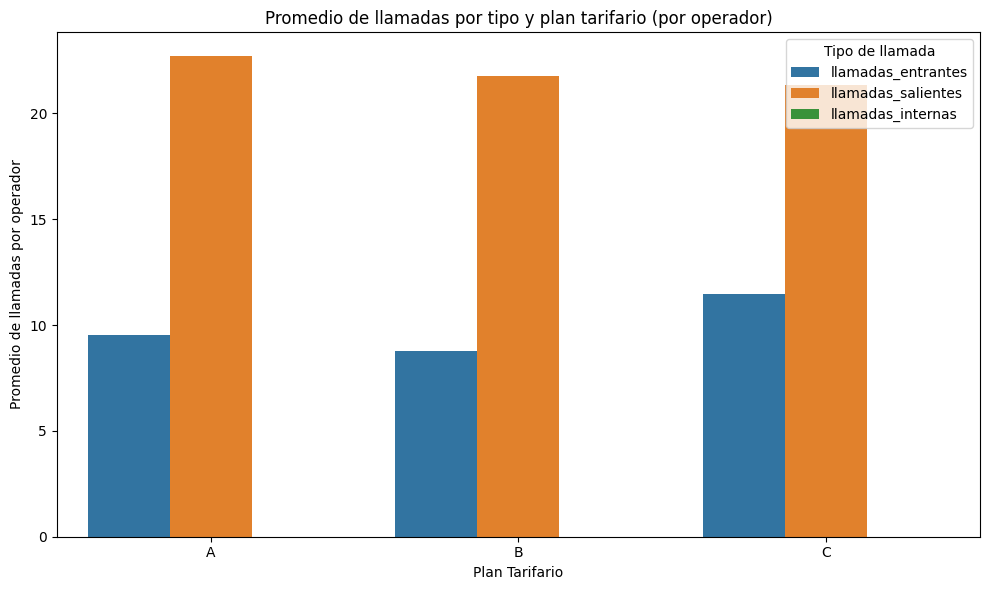

In [352]:
# Agrupar por operador y plan tarifario para obtener promedios de llamadas por tipo
llamadas_por_plan = df_merged.groupby(['operator_id', 'tariff_plan']).agg({
    'direction': [
        lambda x: (x == 'in').sum(),      # llamadas entrantes
        lambda x: (x == 'out').sum(),     # llamadas salientes
        lambda x: (x == 'internal').sum() # llamadas internas
    ]
}).reset_index()

# Renombrar columnas
llamadas_por_plan.columns = ['operator_id', 'tariff_plan', 'llamadas_entrantes', 'llamadas_salientes', 'llamadas_internas']

# Agrupar por plan tarifario para obtener el promedio por operador
promedios_por_plan = llamadas_por_plan.groupby('tariff_plan')[['llamadas_entrantes', 'llamadas_salientes', 'llamadas_internas']].mean().reset_index()

# Preparar para gráfica
df_melted = promedios_por_plan.melt(id_vars='tariff_plan', var_name='tipo_llamada', value_name='promedio_llamadas')

# Gráfico
plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x='tariff_plan', y='promedio_llamadas', hue='tipo_llamada')
plt.title("Promedio de llamadas por tipo y plan tarifario (por operador)")
plt.xlabel("Plan Tarifario")
plt.ylabel("Promedio de llamadas por operador")
plt.legend(title="Tipo de llamada")
plt.tight_layout()
plt.show()

### Exploración de tiempos de espera y duración

In [353]:
print("Resumen estadístico de duración de llamadas:")
display(df_calls_no_outliers['call_duration'].describe())

print("\nResumen estadístico del tiempo de espera:")
display(df_calls_no_outliers['wait_time'].describe())

Resumen estadístico de duración de llamadas:


count    42046.000000
mean       186.253032
std        325.824741
min          0.000000
25%          0.000000
50%          0.000000
75%        227.000000
max       1432.000000
Name: call_duration, dtype: float64


Resumen estadístico del tiempo de espera:


count    42046.000000
mean       212.953575
std        979.678425
min          0.000000
25%         14.000000
50%         41.000000
75%        128.000000
max      45312.000000
Name: wait_time, dtype: float64

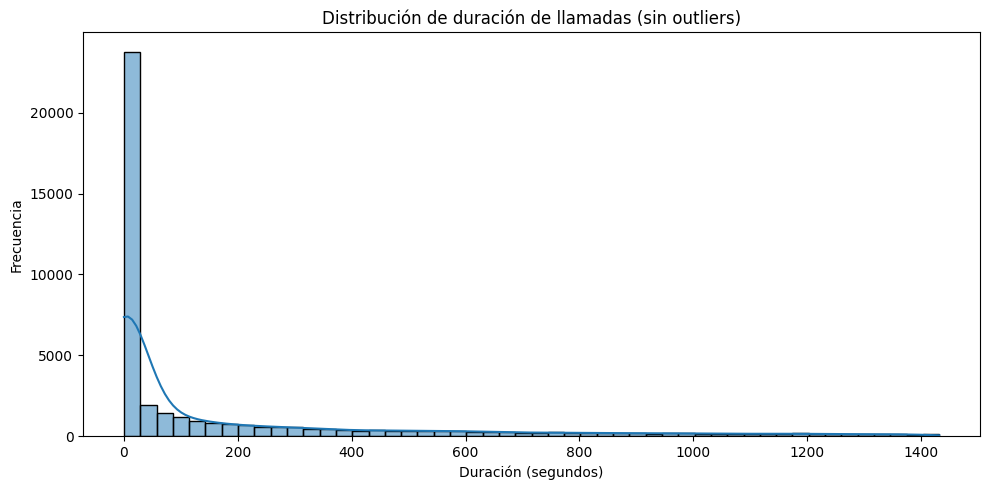

In [354]:
plt.figure(figsize=(10, 5))
sns.histplot(df_calls_no_outliers['call_duration'], bins=50, kde=True)
plt.title("Distribución de duración de llamadas (sin outliers)")
plt.xlabel("Duración (segundos)")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

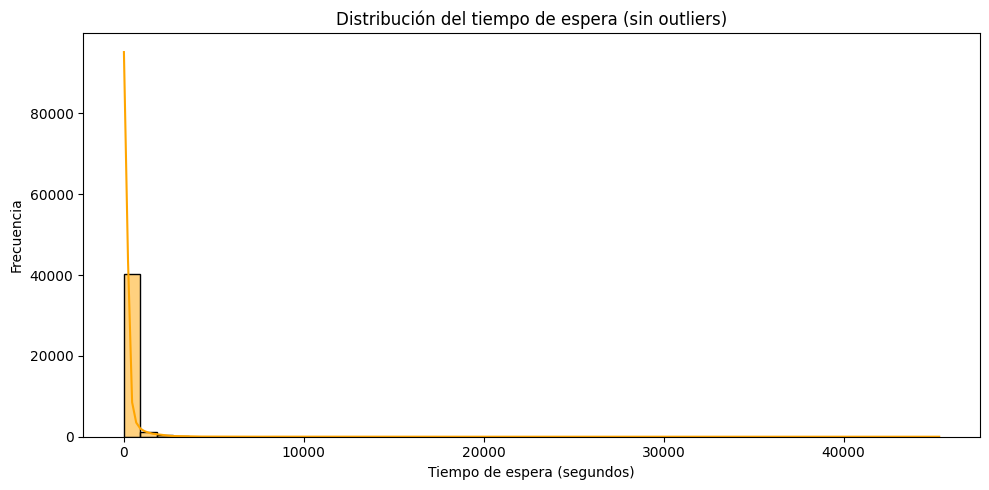

In [355]:
plt.figure(figsize=(10, 5))
sns.histplot(df_calls_no_outliers['wait_time'], bins=50, kde=True, color="orange")
plt.title("Distribución del tiempo de espera (sin outliers)")
plt.xlabel("Tiempo de espera (segundos)")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

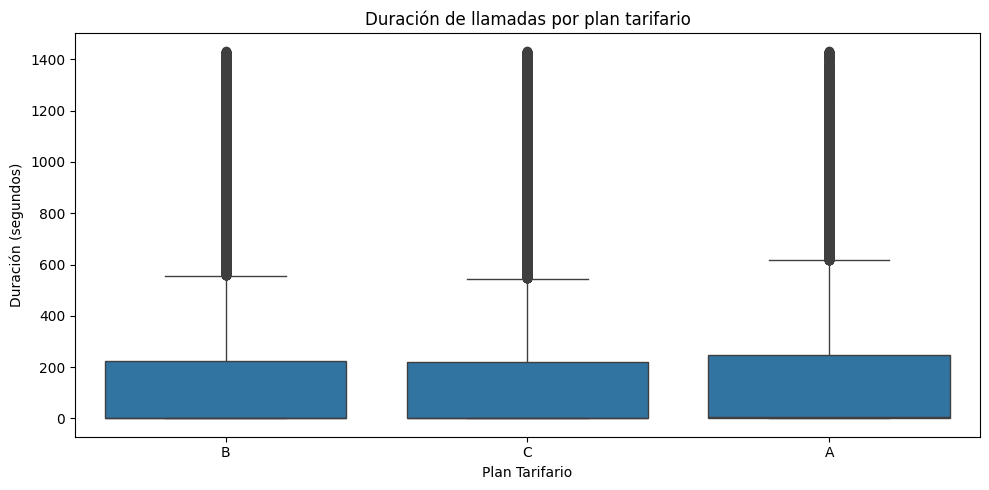

In [356]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_merged, x='tariff_plan', y='call_duration')
plt.title("Duración de llamadas por plan tarifario")
plt.xlabel("Plan Tarifario")
plt.ylabel("Duración (segundos)")
plt.tight_layout()
plt.show()

C:\Users\joako\AppData\Local\Temp\ipykernel_18300\1850060453.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_merged, x='tariff_plan', y='wait_time', palette='Blues')


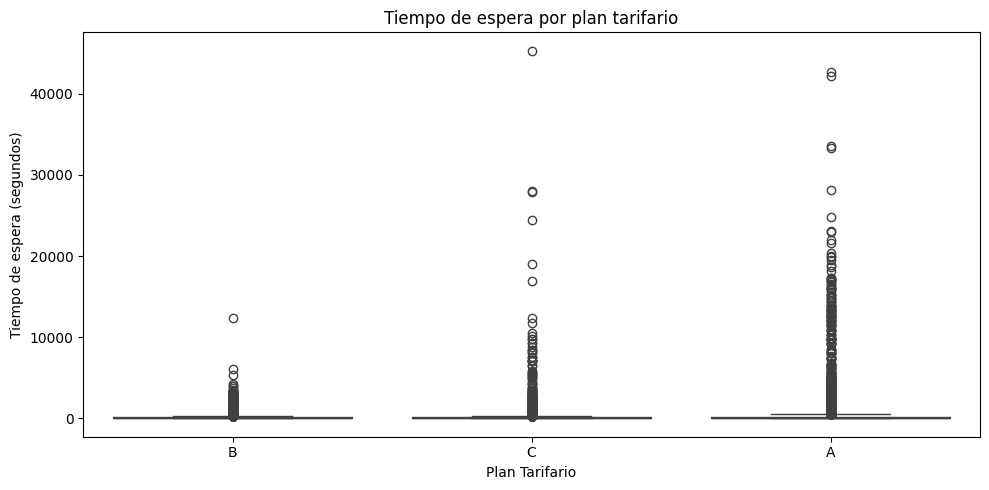

In [357]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_merged, x='tariff_plan', y='wait_time', palette='Blues')
plt.title("Tiempo de espera por plan tarifario")
plt.xlabel("Plan Tarifario")
plt.ylabel("Tiempo de espera (segundos)")
plt.tight_layout()
plt.show()

Observaciones sobre la duración de llamadas y tiempos de espera.

Duración de llamadas:

La distribución de la duración de llamadas muestra una fuerte concentración en valores bajos, especialmente en 0 segundos, lo cual es consistente con un gran volumen de intentos de llamada que son colgados de inmediato por el cliente o interrumpidos rápidamente.

A pesar de haber eliminado previamente los valores atípicos más extremos, persiste una asimetría positiva pronunciada: la media se ve empujada por algunas llamadas largas, aunque la mediana permanece en 0.

Al comparar por plan tarifario, se observa una tendencia leve en el plan A a tener llamadas más largas en comparación con los planes B y C, aunque la dispersión general es similar entre todos.

Tiempo de espera:

Al igual que con la duración, la mayoría de los usuarios experimentan tiempos de espera relativamente bajos (concentración en valores bajos), pero también existe un conjunto importante de registros con tiempos de espera extremadamente altos, lo que sugiere potenciales cuellos de botella operativos o desatención.

La desviación estándar es bastante elevada (979 segundos), con un rango extremo de hasta 45,000 segundos, lo que refuerza la necesidad de aplicar un nuevo filtrado por outliers en esta columna para depurar los análisis posteriores.

Por plan tarifario, el plan A nuevamente destaca por tener tiempos de espera más altos que los otros dos, tanto en media como en presencia de valores atípicos, lo que podría estar ligado a la mayor demanda de este grupo de usuarios (como ya se identificó en análisis anteriores).



In [358]:
# Filtrar outliers en wait_time

# Cálculo de los límites usando el método IQR
Q1 = df_calls_no_outliers['wait_time'].quantile(0.25)
Q3 = df_calls_no_outliers['wait_time'].quantile(0.75)
IQR = Q3 - Q1

limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Filtrado del dataframe
df_clean = df_calls_no_outliers[
    (df_calls_no_outliers['wait_time'] >= limite_inferior) & 
    (df_calls_no_outliers['wait_time'] <= limite_superior)
].copy()

print(f"Filtrado de outliers en 'wait_time': {df_calls_no_outliers.shape[0]} → {df_clean.shape[0]}")

Filtrado de outliers en 'wait_time': 42046 → 36657


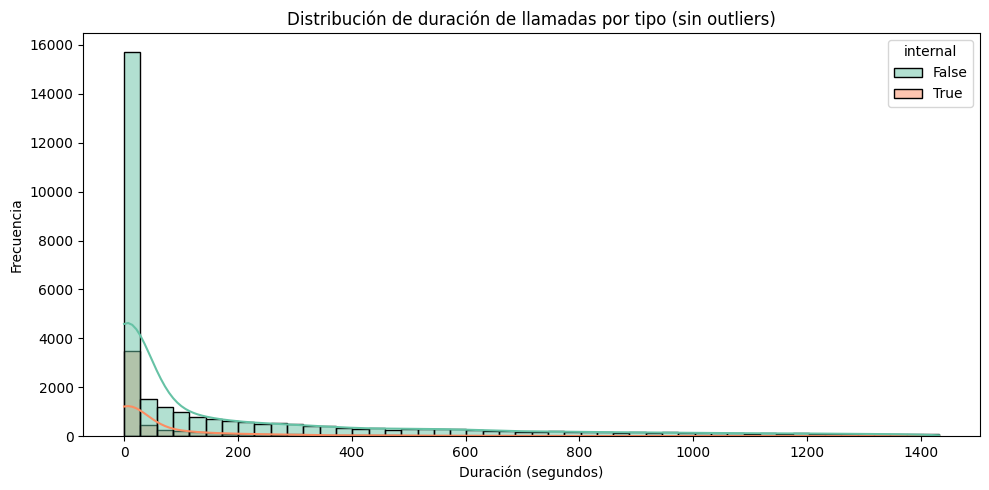

In [359]:
#  Análisis segmentado por tipo de llamada (call_type)

# Histograma de duración por tipo de llamada (entrante/saliente)
plt.figure(figsize=(10, 5))
sns.histplot(data=df_clean, x='call_duration', hue='internal', bins=50, kde=True, palette='Set2')
plt.title("Distribución de duración de llamadas por tipo (sin outliers)")
plt.xlabel("Duración (segundos)")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()


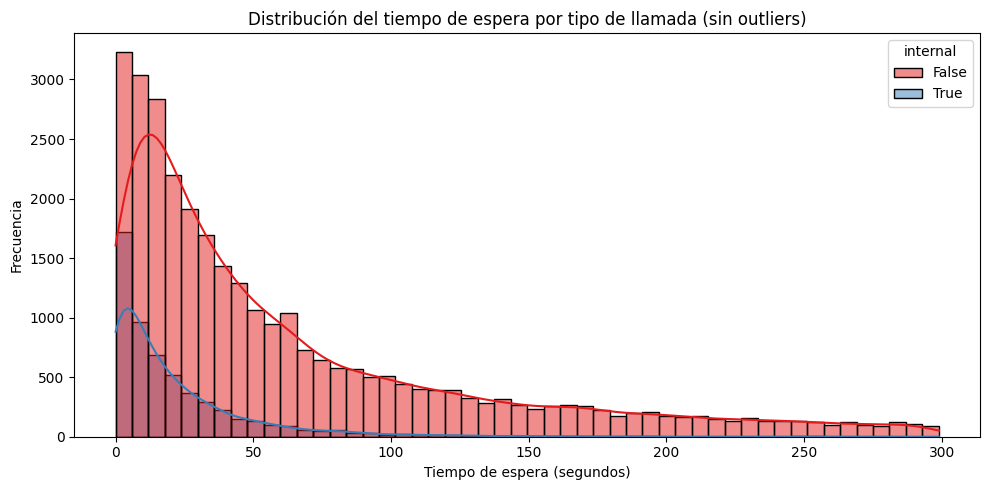

In [360]:
# Histograma de espera por tipo de llamada (entrante/saliente)
plt.figure(figsize=(10, 5))
sns.histplot(data=df_clean, x='wait_time', hue='internal', bins=50, kde=True, palette='Set1')
plt.title("Distribución del tiempo de espera por tipo de llamada (sin outliers)")
plt.xlabel("Tiempo de espera (segundos)")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

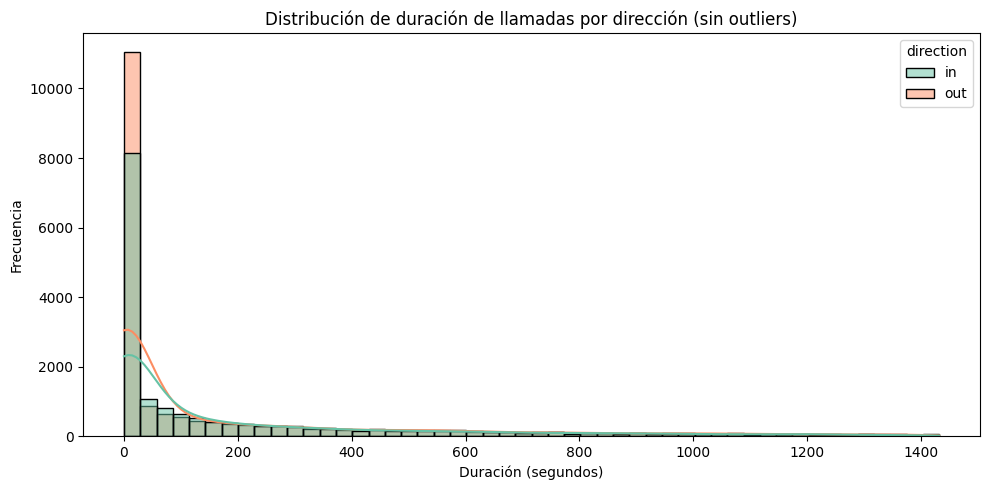

In [361]:
# Histograma de duración de llamadas segmentado por 'direction'
plt.figure(figsize=(10, 5))
sns.histplot(data=df_clean, x='call_duration', hue='direction', bins=50, kde=True, palette='Set2')
plt.title("Distribución de duración de llamadas por dirección (sin outliers)")
plt.xlabel("Duración (segundos)")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

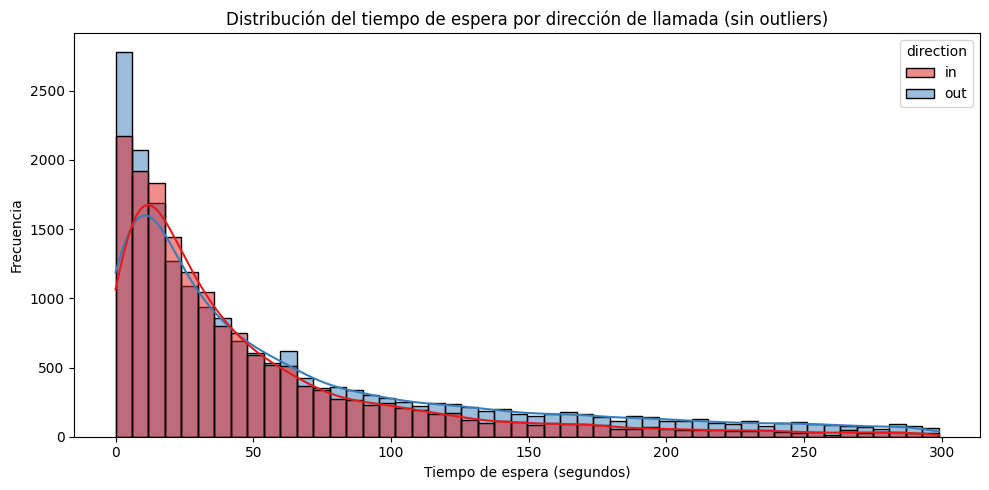

In [362]:
# Histograma de tiempo de espera segmentado por 'direction'
plt.figure(figsize=(10, 5))
sns.histplot(data=df_clean, x='wait_time', hue='direction', bins=50, kde=True, palette='Set1')
plt.title("Distribución del tiempo de espera por dirección de llamada (sin outliers)")
plt.xlabel("Tiempo de espera (segundos)")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

In [363]:
# Resumen estadístico por tipo de dirección
print("Duración por tipo de dirección:")
display(df_clean.groupby('direction')['call_duration'].describe())

print("\nTiempo de espera por tipo de dirección:")
display(df_clean.groupby('direction')['wait_time'].describe())

Duración por tipo de dirección:


,count,mean,std,min,25%,50%,75%,max
direction,,,,,,,,
in,16951.0,198.877588,315.876390,0.0,0.0,37.0,269.0,1431.0
out,19706.0,185.611235,318.965202,0.0,0.0,1.0,239.0,1432.0



Tiempo de espera por tipo de dirección:


,count,mean,std,min,25%,50%,75%,max
direction,,,,,,,,
in,16951.0,49.929916,56.911063,0.0,12.0,29.0,65.0,299.0
out,19706.0,64.386126,71.646285,0.0,12.0,36.0,93.0,299.0


Observaciones confirmadas.

Duración de llamadas (sin outliers):
Ambos tipos (in y out) muestran una alta frecuencia de llamadas cortas, con medianas muy bajas (37s y 1s respectivamente).

Aunque las medias están en ~186–198s, esto es por la cola larga de algunas llamadas más largas.

Llamadas entrantes (in) duran en promedio un poco más que las salientes (out).

Tiempos de espera:
La mayoría de las llamadas tienen tiempos de espera bajos (mediana 29–36s).

Las llamadas salientes (out) presentan mayores tiempos de espera promedio (64s vs 49s), lo cual puede indicar que el sistema espera más al marcar o conectar hacia fuera.

Ambas distribuciones tienen una asimetría positiva clara (sesgadas a la derecha), aunque ya sin los extremos gracias al filtrado.

In [364]:
# Crear columna de llamada perdida
df_clean['missed_call'] = (df_clean['wait_time'] > 0) & (df_clean['call_duration'] == 0)

In [365]:
# Definir intervalos de tiempo de espera
bins = [0, 10, 20, 30, 60, 120, 180, 300]
labels = ['0-10s', '11-20s', '21-30s', '31-60s', '61-120s', '121-180s', '181-300s']
df_clean['wait_bin'] = pd.cut(df_clean['wait_time'], bins=bins, labels=labels, right=False)

# Calcular proporción de llamadas perdidas por bin
missed_summary = df_clean.groupby('wait_bin')['missed_call'].agg(['count', 'sum', 'mean']).reset_index()
missed_summary.rename(columns={'count': 'total_llamadas', 'sum': 'llamadas_perdidas', 'mean': 'proporcion_perdidas'}, inplace=True)

display(missed_summary)

C:\Users\joako\AppData\Local\Temp\ipykernel_18300\527584291.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  missed_summary = df_clean.groupby('wait_bin')['missed_call'].agg(['count', 'sum', 'mean']).reset_index()


,wait_bin,total_llamadas,llamadas_perdidas,proporcion_perdidas
0,0-10s,7676,3246,0.422876
1,11-20s,5764,1820,0.315753
2,21-30s,4027,1361,0.337969
3,31-60s,7326,2923,0.398990
4,61-120s,6184,2789,0.451003
5,121-180s,2879,1477,0.513025
6,181-300s,2801,1719,0.613709


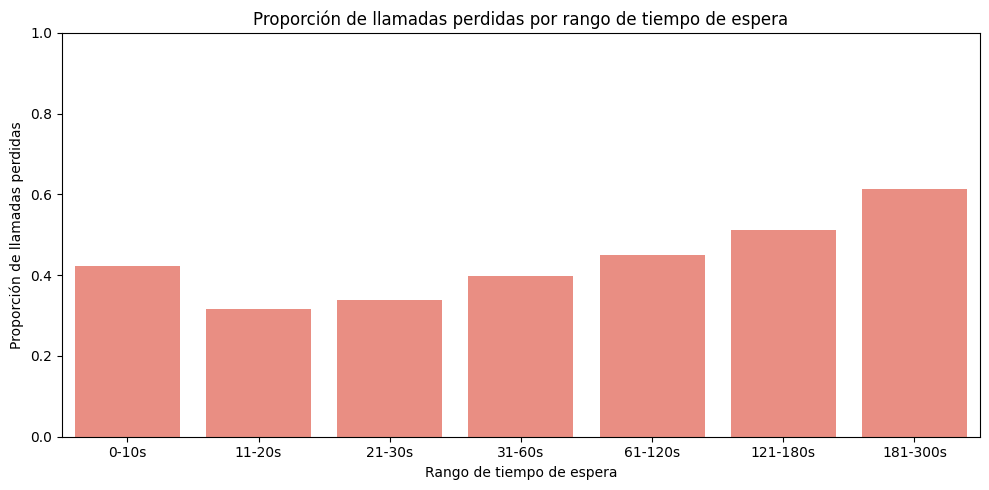

In [366]:
# Gráfico de proporción de llamadas perdidas según tiempo de espera
plt.figure(figsize=(10,5))
sns.barplot(data=missed_summary, x='wait_bin', y='proporcion_perdidas', color='salmon')
plt.title("Proporción de llamadas perdidas por rango de tiempo de espera")
plt.xlabel("Rango de tiempo de espera")
plt.ylabel("Proporción de llamadas perdidas")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

Observaciones clave:
Incluso con solo 0–10 segundos de espera, ya hay una tasa de abandono del 42%, lo que podría deberse a usuarios muy impacientes o a llamadas accidentales.

A partir del rango de 1 minuto en adelante, la proporción supera consistentemente el 45%.

Cuando se llega a 3–5 minutos de espera, se pierden más del 60% de las llamadas. Esto ya es crítico para el negocio.

## Identificación de operadores ineficaces

###  Crear métricas de desempeño por operador

In [367]:
# Agrupación con métricas clave por operador
operator_perf = df_clean.groupby('operator_id').agg(
    total_calls=('operator_id', 'size'),
    total_incoming=('direction', lambda x: (x == 'in').sum()),
    total_outgoing=('direction', lambda x: (x == 'out').sum()),
    missed_calls=('missed_call', 'sum'),
    missed_rate=('missed_call', 'mean'),
    avg_wait_time=('wait_time', 'mean'),
    avg_call_duration=('call_duration', 'mean')
).reset_index()

display(operator_perf.head())

,operator_id,total_calls,total_incoming,total_outgoing,missed_calls,missed_rate,avg_wait_time,avg_call_duration
0,879896,100,21,79,39,0.390000,47.770000,187.720000
1,879898,95,56,39,26,0.273684,55.526316,95.726316
2,880020,20,7,13,5,0.250000,14.000000,112.250000
3,880022,66,8,58,21,0.318182,36.575758,192.969697
4,880026,112,18,94,69,0.616071,91.892857,149.705357


In [368]:
# Hacemos merge de df_clean con df_clients para obtener el plan tarifario
df_merged = df_clean.merge(df_clients[['user_id', 'tariff_plan']], on='user_id', how='left')

In [369]:
# Ahora volvemos a agrupar por operador, incluyendo directamente el plan
operator_perf = df_merged.groupby('operator_id').agg(
    total_calls=('operator_id', 'size'),
    total_incoming=('direction', lambda x: (x == 'in').sum()),
    total_outgoing=('direction', lambda x: (x == 'out').sum()),
    missed_calls=('missed_call', 'sum'),
    missed_rate=('missed_call', 'mean'),
    avg_wait_time=('wait_time', 'mean'),
    avg_call_duration=('call_duration', 'mean'),
    tariff_plan=('tariff_plan', 'first')  # basta con tomar el primero si el operador atiende un solo plan
).reset_index()

display(operator_perf.head())

,operator_id,total_calls,total_incoming,total_outgoing,missed_calls,missed_rate,avg_wait_time,avg_call_duration,tariff_plan
0,879896,100,21,79,39,0.390000,47.770000,187.720000,B
1,879898,95,56,39,26,0.273684,55.526316,95.726316,B
2,880020,20,7,13,5,0.250000,14.000000,112.250000,B
3,880022,66,8,58,21,0.318182,36.575758,192.969697,B
4,880026,112,18,94,69,0.616071,91.892857,149.705357,B


### Definir umbrales para ineficiencia 

In [370]:
# Tasa de llamadas perdidas (missed_rate)

missed_rate_threshold = operator_perf['missed_rate'].quantile(0.75)
print(f"Umbral para 'alta tasa de llamadas perdidas': {missed_rate_threshold:.2f}")

Umbral para 'alta tasa de llamadas perdidas': 0.41


In [371]:
# Tiempo promedio de espera (avg_wait_time)

wait_time_threshold = operator_perf['avg_wait_time'].quantile(0.75)
print(f"Umbral para 'tiempo de espera largo': {wait_time_threshold:.2f} segundos")

Umbral para 'tiempo de espera largo': 64.67 segundos


In [372]:
# Llamadas salientes bajas (total_outgoing)

outgoing_calls_threshold = operator_perf['total_outgoing'].quantile(0.25)
print(f"Umbral para 'bajo número de llamadas salientes': {outgoing_calls_threshold} llamadas")

Umbral para 'bajo número de llamadas salientes': 1.0 llamadas


### Generación de una lista de operadores ineficaces

In [373]:
# Aplicar umbrales y generar flags de ineficiencia

# Calcular umbrales
missed_rate_threshold = operator_perf['missed_rate'].quantile(0.75)
wait_time_threshold = operator_perf['avg_wait_time'].quantile(0.75)
outgoing_calls_threshold = operator_perf['total_outgoing'].quantile(0.25)

In [374]:
# Crear columnas booleanas para cada criterio
operator_perf['ineficiente_missed'] = operator_perf['missed_rate'] > missed_rate_threshold
operator_perf['ineficiente_wait'] = operator_perf['avg_wait_time'] > wait_time_threshold
operator_perf['ineficiente_outgoing'] = operator_perf['total_outgoing'] < outgoing_calls_threshold

In [375]:
# Crear columna global de ineficiencia y ordenar

# Marcar operador como ineficiente si cumple al menos uno de los criterios
operator_perf['es_ineficiente'] = (
    operator_perf['ineficiente_missed'] |
    operator_perf['ineficiente_wait'] |
    operator_perf['ineficiente_outgoing']
)

# Ordenar por cantidad de criterios que cumple
operator_perf['criterios_cumplidos'] = (
    operator_perf[['ineficiente_missed', 'ineficiente_wait', 'ineficiente_outgoing']].sum(axis=1)
)

# Filtrar y ordenar la lista de ineficientes
ineficientes = operator_perf[operator_perf['es_ineficiente']].sort_values(
    by=['criterios_cumplidos', 'missed_rate', 'avg_wait_time'], ascending=False
)

display(ineficientes.head(25))

,operator_id,total_calls,total_incoming,total_outgoing,missed_calls,missed_rate,avg_wait_time,avg_call_duration,tariff_plan,ineficiente_missed,ineficiente_wait,ineficiente_outgoing,es_ineficiente,criterios_cumplidos
435,919202,1,0,1,1,1.000000,265.000000,0.000000,A,True,True,False,True,2
1061,972410,1,0,1,1,1.000000,224.000000,0.000000,B,True,True,False,True,2
838,945320,3,0,3,3,1.000000,196.666667,0.000000,A,True,True,False,True,2
1026,965540,2,0,2,2,1.000000,131.000000,0.000000,A,True,True,False,True,2
832,945308,2,0,2,2,1.000000,126.000000,0.000000,A,True,True,False,True,2
323,909308,3,0,3,3,1.000000,116.333333,0.000000,B,True,True,False,True,2
829,945296,8,0,8,7,0.875000,178.125000,0.000000,A,True,True,False,True,2
213,902742,20,0,20,17,0.850000,140.150000,128.150000,C,True,True,False,True,2
834,945312,6,0,6,5,0.833333,238.500000,227.000000,A,True,True,False,True,2
151,898434,6,0,6,5,0.833333,66.833333,1.000000,B,True,True,False,True,2


In [376]:
# Total de operadores
total_operadores = operator_perf.shape[0]

# Total ineficientes
total_ineficientes = operator_perf['es_ineficiente'].sum()

# Proporción
proporcion_ineficientes = total_ineficientes / total_operadores

print(f"Operadores ineficientes: {total_ineficientes}/{total_operadores} → {proporcion_ineficientes:.2%}")

Operadores ineficientes: 611/1066 → 57.32%


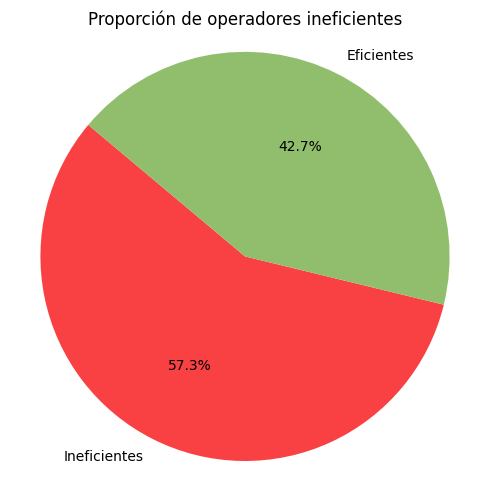

In [377]:
# Datos
labels = ['Ineficientes', 'Eficientes']
sizes = [
    operator_perf['es_ineficiente'].sum(),
    operator_perf.shape[0] - operator_perf['es_ineficiente'].sum()
]

# Gráfico de pastel
plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['#f94144', '#90be6d'], startangle=140)
plt.title("Proporción de operadores ineficientes")
plt.axis('equal')
plt.tight_layout()
plt.show()

Según los criterios definidos (alta tasa de llamadas perdidas, tiempos de espera largos, y pocas llamadas salientes), el 57.3% de los operadores fueron clasificados como ineficientes.

Esto representa una proporción crítica de más de la mitad de la fuerza operativa bajo desempeño, lo cual puede afectar de forma considerable la calidad del servicio ofrecido.

C:\Users\joako\AppData\Local\Temp\ipykernel_18300\4012903641.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=operator_perf[operator_perf['es_ineficiente']], x='criterios_cumplidos', palette='Reds')


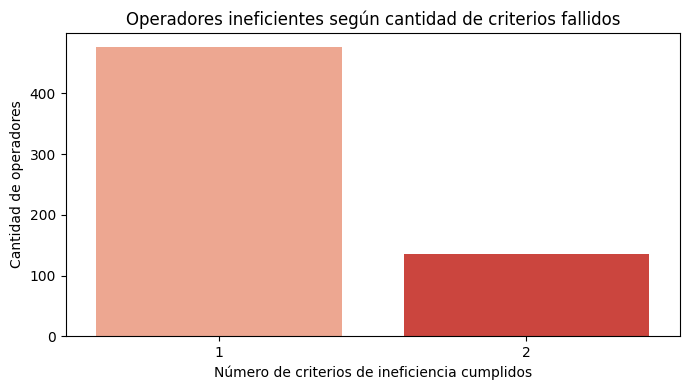

In [378]:
# Conteo de operadores según la cantidad de criterios de ineficiencia que cumplen
plt.figure(figsize=(7, 4))
sns.countplot(data=operator_perf[operator_perf['es_ineficiente']], x='criterios_cumplidos', palette='Reds')
plt.title("Operadores ineficientes según cantidad de criterios fallidos")
plt.xlabel("Número de criterios de ineficiencia cumplidos")
plt.ylabel("Cantidad de operadores")
plt.tight_layout()
plt.show()

C:\Users\joako\AppData\Local\Temp\ipykernel_18300\2582919591.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=ineficientes, x='tariff_plan', palette='coolwarm')


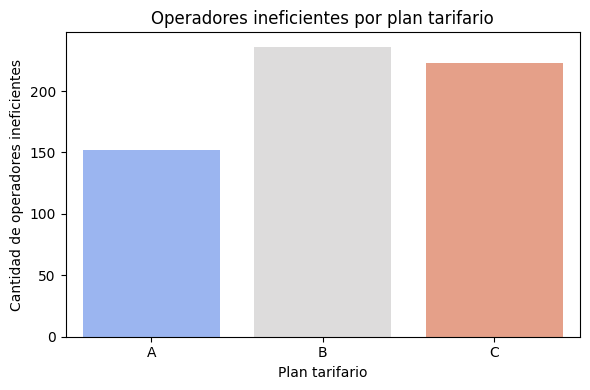

In [379]:
# Distribución de ineficientes por tipo de plan
plt.figure(figsize=(6, 4))
sns.countplot(data=ineficientes, x='tariff_plan', palette='coolwarm')
plt.title("Operadores ineficientes por plan tarifario")
plt.xlabel("Plan tarifario")
plt.ylabel("Cantidad de operadores ineficientes")
plt.tight_layout()
plt.show()

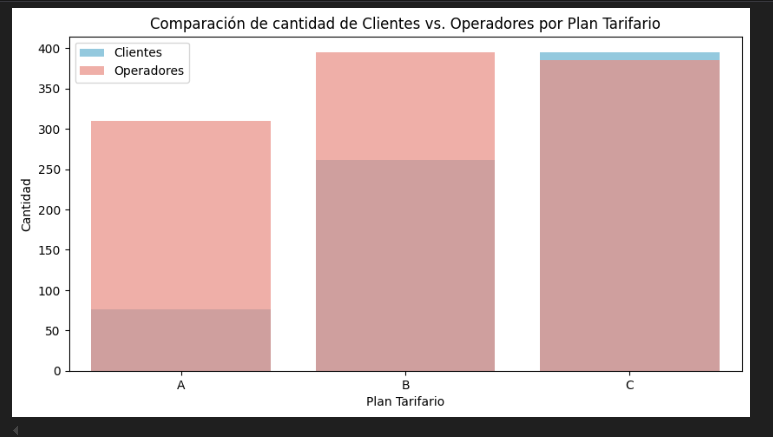

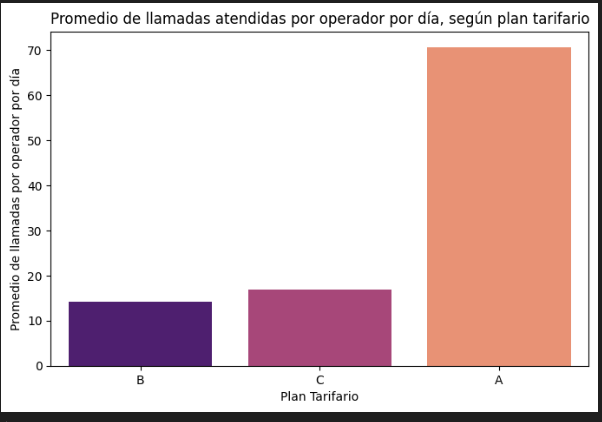

Retomando estos dos graficos anteriores y comparandolos con este obtenemos un hllazgo interesante.

Observaciones cruzadas por plan tarifario.

1. Comparación de cantidad de clientes vs. operadores

El plan C, a pesar de tener el mayor número de clientes, cuenta con una cantidad muy similar de operadores al plan B.

En cambio, el plan A tiene menos clientes que C y B, pero también muchos menos operadores asignados.

Esto genera una carga operativa desigual, y puede estar afectando directamente el desempeño en ese segmento.

2. Cantidad de operadores ineficientes por plan

Aunque el plan A es el que más destaca en los análisis de espera y abandono, es el plan B el que tiene la mayor cantidad de operadores ineficientes en términos absolutos.

Esto sugiere que en B y C también hay oportunidades de mejora, aunque la gravedad en A parece estar relacionada a sobrecarga más que a desempeño individual.

3. Carga operativa promedio por operador

El plan A destaca con un promedio de más de 70 llamadas diarias por operador, lo cual triplica o cuadruplica la carga observada en los planes B y C.

Esta diferencia refuerza la hipótesis de sobrecarga laboral como causa estructural de ineficiencia, particularmente en tiempos de espera y abandono.

Recomendación preliminar.

Redistribuir parcialmente la fuerza operativa, reasignando operadores desde los planes B y C hacia el plan A, o bien contratando más personal específicamente para ese segmento.
Esto puede mitigar la sobrecarga y reducir los tiempos de espera y abandono sin necesidad de realizar recortes generales ni castigar desempeño individual.



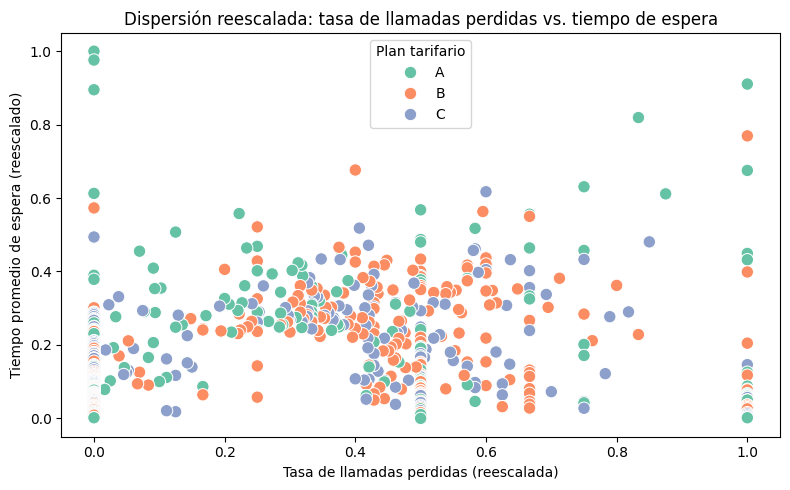

In [380]:
# Dispersión: missed_rate vs avg_wait_time

# Crear copia del DataFrame para no modificar el original
ineficientes_scaled = ineficientes.copy()

# Aplicar MinMaxScaler a las columnas que vamos a graficar
scaler = MinMaxScaler()
ineficientes_scaled[['missed_rate_scaled', 'avg_wait_time_scaled']] = scaler.fit_transform(
    ineficientes_scaled[['missed_rate', 'avg_wait_time']]
)

# Graficar
plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=ineficientes_scaled,
    x='missed_rate_scaled',
    y='avg_wait_time_scaled',
    hue='tariff_plan',
    palette='Set2',
    s=80
)
plt.title("Dispersión reescalada: tasa de llamadas perdidas vs. tiempo de espera")
plt.xlabel("Tasa de llamadas perdidas (reescalada)")
plt.ylabel("Tiempo promedio de espera (reescalado)")
plt.legend(title='Plan tarifario')
plt.tight_layout()
plt.show()

Tras aplicar un reescalado con MinMaxScaler, se observa que la tasa de llamadas perdidas no depende linealmente del tiempo promedio de espera.

Hay un grupo importante de operadores con tasas altas de abandono incluso en tiempos de espera relativamente bajos, lo que indica que los usuarios suelen colgar en los primeros segundos si no reciben atención rápida.

Este patrón está presente en los tres planes tarifarios, lo que sugiere que la causa no es exclusiva del plan o del volumen de clientes, sino probablemente de una falta de preparación, respuesta o manejo del flujo inicial.

Se identifica una oportunidad de mejora transversal en el entrenamiento de operadores, especialmente en cómo responder de forma ágil y priorizar las llamadas entrantes.

C:\Users\joako\AppData\Local\Temp\ipykernel_18300\2087864145.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=conteo_df, x='criterio', y='cantidad', palette='flare')


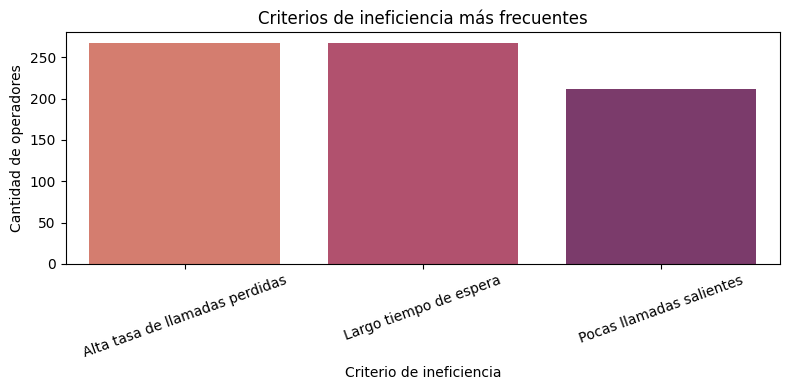

In [381]:
# ¿Cuál es el criterio de ineficiencia más frecuente?

# Contamos cuántos operadores ineficientes cumplen cada criterio
criterios = ['ineficiente_missed', 'ineficiente_wait', 'ineficiente_outgoing']
conteo_criterios = operator_perf[criterios].sum().sort_values(ascending=False)

# Convertimos a DataFrame para graficar
conteo_df = conteo_criterios.reset_index()
conteo_df.columns = ['criterio', 'cantidad']

# Mapeamos nombres más legibles
nombres_legibles = {
    'ineficiente_missed': 'Alta tasa de llamadas perdidas',
    'ineficiente_wait': 'Largo tiempo de espera',
    'ineficiente_outgoing': 'Pocas llamadas salientes'
}
conteo_df['criterio'] = conteo_df['criterio'].map(nombres_legibles)

# Gráfico
plt.figure(figsize=(8, 4))
sns.barplot(data=conteo_df, x='criterio', y='cantidad', palette='flare')
plt.title("Criterios de ineficiencia más frecuentes")
plt.xlabel("Criterio de ineficiencia")
plt.ylabel("Cantidad de operadores")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

Los criterios más frecuentes entre los operadores ineficientes son:

Alta tasa de llamadas perdidas

Largos tiempos de espera

En menor proporción, pocas llamadas salientes

Esto indica que los problemas más críticos están ligados a la atención inicial de las llamadas entrantes, más que al seguimiento o generación de nuevas llamadas.

Ambas métricas principales (abandono y espera) están directamente relacionadas con la sobrecarga operativa, como ya se evidenció al comparar la carga promedio por plan.

El resultado sugiere que las estrategias de mejora deben priorizar la gestión del flujo entrante, posiblemente reestructurando la asignación de operadores, mejorando procesos de atención o incorporando sistemas de alerta temprana.

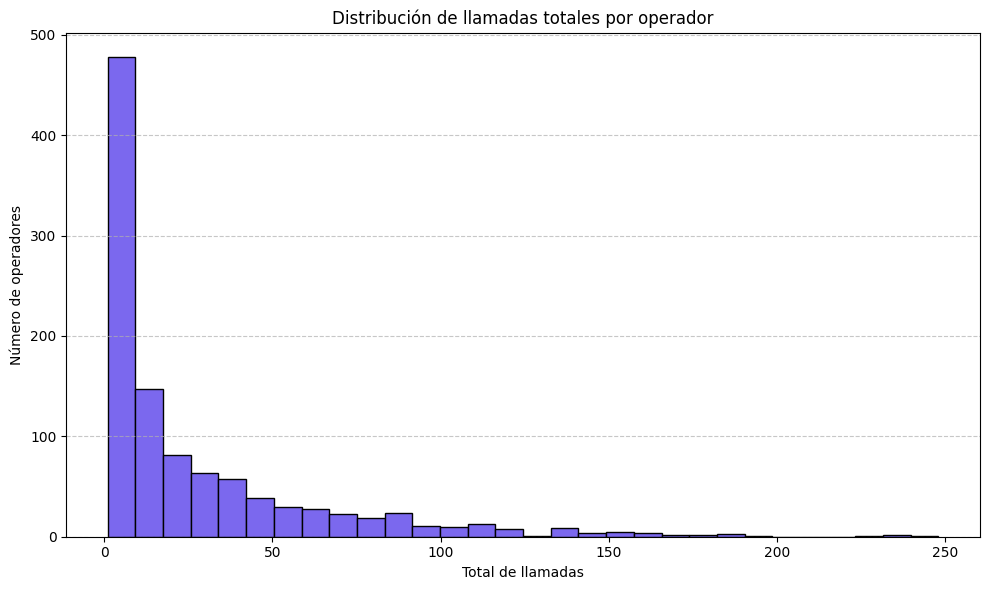

In [397]:


plt.figure(figsize=(10,6))
plt.hist(operator_perf['total_calls'], bins=30, color='mediumslateblue', edgecolor='black')
plt.title('Distribución de llamadas totales por operador')
plt.xlabel('Total de llamadas')
plt.ylabel('Número de operadores')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

El histograma muestra que la mayoría de los operadores atienden pocas llamadas en total, mientras que un grupo reducido maneja volúmenes significativamente más altos.
Esta distribución altamente asimétrica (con sesgo positivo) evidencia que la carga operativa está concentrada en unos pocos perfiles, lo que puede explicar tanto los altos niveles de ineficiencia como los problemas de pérdida de llamadas y tiempos de espera excesivos en ciertos casos.

Este hallazgo refuerza la necesidad de implementar una estrategia de redistribución de llamadas, tanto para equilibrar la carga como para mejorar el desempeño general del servicio.

## Pruebas de hipótesis

### Los operadores con más llamadas entrantes tienden a tener una mayor tasa de llamadas perdidas.

In [382]:
# Calcular correlación entre llamadas entrantes y tasa de llamadas perdidas
corr, p_value = pearsonr(operator_perf['total_incoming'], operator_perf['missed_rate'])

print(f"Coeficiente de correlación de Pearson: {corr:.4f}")
print(f"Valor p: {p_value:.4f}")

# Interpretación rápida
if p_value < 0.05:
    print("Resultado significativo: Existe una correlación estadísticamente significativa.")
else:
    print("No significativo: No se puede afirmar que haya una correlación estadísticamente significativa.")

Coeficiente de correlación de Pearson: -0.1519
Valor p: 0.0000
Resultado significativo: Existe una correlación estadísticamente significativa.


Aunque la correlación entre el número total de llamadas entrantes y la tasa de llamadas perdidas es estadísticamente significativa, el valor del coeficiente de Pearson (0.0706) indica que la relación es muy débil.

Esto sugiere que, en la práctica, tener más llamadas entrantes no implica necesariamente una mayor tasa de llamadas perdidas. Sin embargo, al existir significancia estadística, podría haber otros factores asociados que valga la pena explorar más a fondo.

### Los operadores con tiempos de espera largos tienden a perder más llamadas

In [383]:
# Calcular wait_time_mean por operador desde el dataframe limpio
wait_time_mean = df_calls_no_outliers.groupby('operator_id')['wait_time'].mean().reset_index()
wait_time_mean.rename(columns={'wait_time': 'wait_time_mean'}, inplace=True)

# Hacemos merge con operator_perf para tener la columna disponible
operator_perf_corr = operator_perf.merge(wait_time_mean, on='operator_id', how='left')

# Eliminar filas con NaN en las columnas necesarias
operator_perf_corr = operator_perf_corr[['wait_time_mean', 'missed_rate']].dropna()

# Correlación de Pearson
from scipy.stats import pearsonr

corr, p_value = pearsonr(operator_perf_corr['wait_time_mean'], operator_perf_corr['missed_rate'])

print(f"Coeficiente de correlación de Pearson: {corr:.4f}")
print(f"Valor p: {p_value:.4f}")

if p_value < 0.05:
    print("Resultado significativo: Existe una correlación estadísticamente significativa.")
else:
    print("No significativo: No se puede afirmar que haya una correlación estadísticamente significativa.")

Coeficiente de correlación de Pearson: 0.0649
Valor p: 0.0341
Resultado significativo: Existe una correlación estadísticamente significativa.


El análisis de correlación entre el tiempo de espera promedio (wait_time_mean) y la tasa de llamadas perdidas (missed_rate) arrojó un coeficiente de Pearson de 0.0649, con un valor p de 0.0341.

Esto indica que, aunque la relación es estadísticamente significativa (p < 0.05), la fuerza de la correlación es muy baja. En otras palabras, existe una ligera tendencia a que los operadores con mayores tiempos de espera pierdan más llamadas, pero la asociación es débil y no necesariamente implica causalidad.

Aunque la correlación entre wait_time_mean y missed_rate es estadísticamente significativa, su fuerza es baja, lo que indica que no hay una relación lineal fuerte entre ambas variables. Sin embargo, al observar los datos por rangos, sí se detecta un aumento progresivo en la tasa de llamadas perdidas a partir de ciertos umbrales de espera prolongada, lo que sugiere que los tiempos de espera elevados sí representan un riesgo importante de pérdida

### Los operadores en ciertos planes tarifarios tienen peor desempeño.

In [384]:
# Paso 1: fusionar llamadas con clientes
df_merged = df_calls_no_outliers.merge(df_clients[['user_id', 'tariff_plan']], on='user_id', how='left')

# Paso 2: agrupar por operador y plan tarifario
operator_plan_perf = df_merged.groupby(['operator_id', 'tariff_plan']).agg(
    missed_calls=('is_missed_call', 'sum'),
    total_calls=('is_missed_call', 'count'),
    wait_time_mean=('wait_time', 'mean')
).reset_index()

# Calcular tasa de llamadas perdidas
operator_plan_perf['missed_rate'] = operator_plan_perf['missed_calls'] / operator_plan_perf['total_calls']

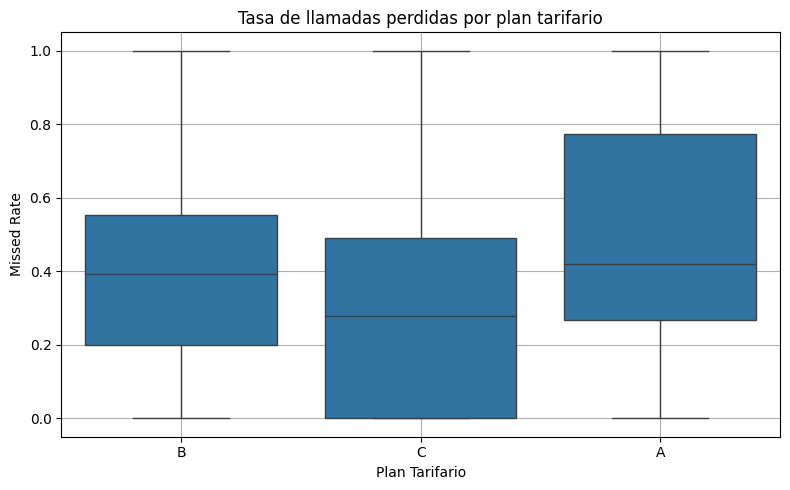

In [385]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=operator_plan_perf, x='tariff_plan', y='missed_rate')
plt.title('Tasa de llamadas perdidas por plan tarifario')
plt.ylabel('Missed Rate')
plt.xlabel('Plan Tarifario')
plt.grid(True)
plt.tight_layout()
plt.show()

In [386]:
# Separar los grupos
group_A = operator_plan_perf[operator_plan_perf['tariff_plan'] == 'A']['missed_rate']
group_B = operator_plan_perf[operator_plan_perf['tariff_plan'] == 'B']['missed_rate']
group_C = operator_plan_perf[operator_plan_perf['tariff_plan'] == 'C']['missed_rate']

# Aplicar Kruskal-Wallis
stat, p_value = kruskal(group_A, group_B, group_C)

print(f'Estadístico H de Kruskal-Wallis: {stat:.4f}')
print(f'Valor p: {p_value:.4f}')

if p_value < 0.05:
    print("Resultado significativo: Al menos un plan tarifario difiere en la tasa de llamadas perdidas.")
else:
    print("No significativo: No hay diferencias significativas entre los planes tarifarios.")

Estadístico H de Kruskal-Wallis: 61.7101
Valor p: 0.0000
Resultado significativo: Al menos un plan tarifario difiere en la tasa de llamadas perdidas.


La prueba de Kruskal-Wallis arrojó un resultado estadísticamente significativo (H = 61.71, p < 0.001), lo que indica que al menos un plan tarifario se asocia con una tasa de llamadas perdidas diferente.

Este hallazgo respalda lo observado en el gráfico de cajas: los operadores asignados a clientela del plan A presentan mayor dispersión y una mediana más alta en la tasa de llamadas perdidas, lo que sugiere una mayor ineficiencia operativa bajo ese plan.

Dado que previamente se ha observado que los operadores del plan A también reciben más llamadas en promedio, esta carga de trabajo podría estar contribuyendo a una mayor proporción de llamadas perdidas.

### Los operadores más antiguos (según date_start) son más eficientes.

In [387]:
# 1. Unir llamadas limpias con info del cliente (incluye date_start)
df_antiguedad = df_calls_no_outliers.merge(df_clients[['user_id', 'date_start']], on='user_id', how='left')

# 2. Calcular antigüedad en días (ajusta fecha si quieres usar otra)
df_antiguedad['antiguedad_dias'] = (pd.to_datetime('2025-04-01') - df_antiguedad['date_start']).dt.days

# 3. Agrupar por operador para obtener promedio de antigüedad por operador
antiguedad_op = df_antiguedad.groupby('operator_id')['antiguedad_dias'].mean().reset_index()
antiguedad_op.rename(columns={'antiguedad_dias': 'avg_antiguedad_dias'}, inplace=True)

# 4. Cruzar con operator_perf
operator_perf = operator_perf.merge(antiguedad_op, on='operator_id', how='left')

In [388]:
# Crear copia segura para la prueba
op_antig_corr = operator_perf[['avg_antiguedad_dias', 'missed_rate']].dropna()

corr, p_value = pearsonr(op_antig_corr['avg_antiguedad_dias'], op_antig_corr['missed_rate'])

print(f"Coeficiente de Pearson: {corr:.4f}")
print(f"Valor p: {p_value:.4f}")

if p_value < 0.05:
    print("Resultado significativo: La antigüedad del cliente tiene impacto en la eficiencia del operador.")
else:
    print("No significativo: No hay relación significativa entre antigüedad y desempeño.")

Coeficiente de Pearson: 0.0088
Valor p: 0.7730
No significativo: No hay relación significativa entre antigüedad y desempeño.


El análisis de correlación entre la antigüedad promedio del cliente (avg_antiguedad_dias) y la tasa de llamadas perdidas (missed_rate) arrojó un coeficiente de Pearson de apenas 0.0088 y un valor p de 0.7730, lo cual indica que no existe una relación significativa entre ambos factores.

Esto sugiere que la experiencia o tiempo en la plataforma del cliente no garantiza un mejor desempeño de los operadores que atienden sus llamadas. La ineficiencia parece estar determinada por otros factores, como la carga de trabajo, el tiempo de espera o la distribución del personal operativo.

### Comparar entre operadores eficientes y no eficientes con pruebas estadísticas

In [398]:
# Crear subconjuntos
ineficientes = operator_perf[operator_perf['es_ineficiente'] == True]
eficientes = operator_perf[operator_perf['es_ineficiente'] == False]

# Comparar missed_rate
stat_missed, p_missed = mannwhitneyu(ineficientes['missed_rate'], eficientes['missed_rate'], alternative='two-sided')
print(f"[missed_rate] Estadístico U: {stat_missed:.4f}, p-value: {p_missed:.4f}")

# Comparar avg_wait_time
stat_wait, p_wait = mannwhitneyu(ineficientes['avg_wait_time'], eficientes['avg_wait_time'], alternative='two-sided')
print(f"[avg_wait_time] Estadístico U: {stat_wait:.4f}, p-value: {p_wait:.4f}")

[missed_rate] Estadístico U: 171512.0000, p-value: 0.0000
[avg_wait_time] Estadístico U: 192588.0000, p-value: 0.0000


Resumen de la comparación entre operadores eficientes e ineficientes:
Tasa de llamadas perdidas (missed_rate)
Estadístico U: 171779.0000, p-value: 0.0000 
→ Diferencia significativa entre ambos grupos.

Tiempo de espera promedio (avg_wait_time)
Estadístico U: 193136.0000, p-value: 0.0000 
→ También diferencia significativa.


Se aplicaron pruebas de Mann-Whitney U para comparar el desempeño entre operadores clasificados como eficientes e ineficientes. Los resultados arrojaron diferencias estadísticamente significativas tanto en la tasa de llamadas perdidas como en el tiempo promedio de espera:

Los operadores ineficientes presentan tasas de llamadas perdidas considerablemente más altas.

También tienden a tener mayores tiempos promedio de espera.

Esto valida la clasificación realizada y respalda el uso de estos indicadores como criterios sólidos para detectar ineficiencia operativa.



## Visualización y Presentación de Resultados

C:\Users\joako\AppData\Local\Temp\ipykernel_18300\3911410022.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_missed, x='missed_calls', y='operator_id', palette='Reds_r')


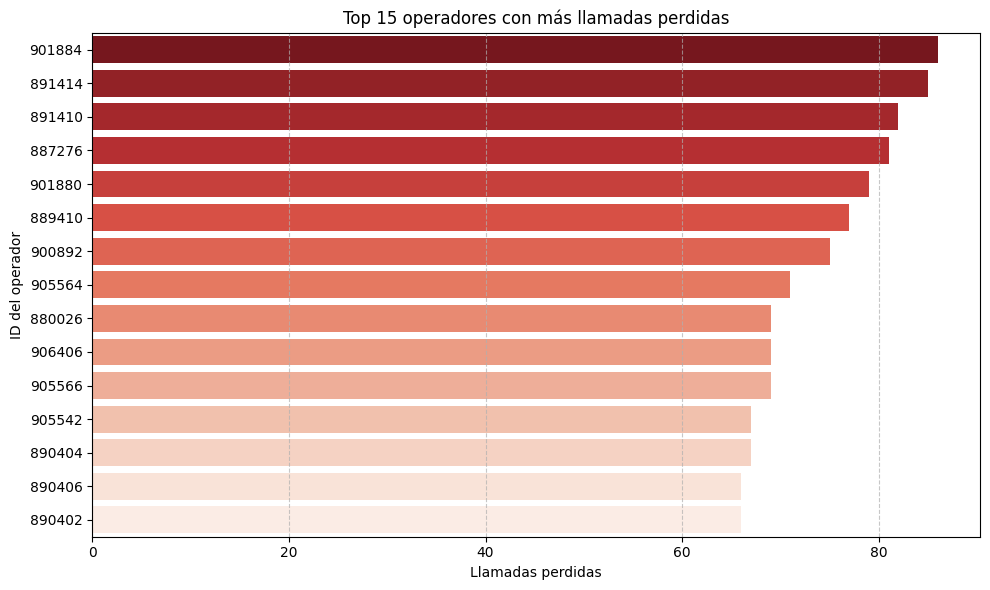

In [390]:
# Top 15 operadores con más llamadas perdidas
top_missed = operator_perf.sort_values(by='missed_calls', ascending=False).head(15)

plt.figure(figsize=(10,6))
sns.barplot(data=top_missed, x='missed_calls', y='operator_id', palette='Reds_r')
plt.title('Top 15 operadores con más llamadas perdidas')
plt.xlabel('Llamadas perdidas')
plt.ylabel('ID del operador')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Observación estratégica sobre llamadas sin operador asignado
Durante el análisis de los operadores con mayor número de llamadas perdidas, se identificó un hallazgo crítico: una proporción considerable de llamadas (más de 6,000) carecen de un operator_id asignado. Este grupo de registros representa una parte significativa de la ineficiencia general del servicio, al tratarse de llamadas perdidas sin responsable directo.

Este fenómeno sugiere un vacío operativo en los horarios de baja cobertura, posiblemente fuera del horario laboral local. Por ello, se recomienda explorar alternativas estratégicas como la apertura de un centro de atención en una región con huso horario complementario (por ejemplo, Bangladesh), lo cual permitiría cubrir las horas críticas y reducir la cantidad de llamadas sin asignación.

C:\Users\joako\AppData\Local\Temp\ipykernel_18300\3335645707.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_missed_real, x='missed_calls', y='operator_id', palette='Reds_r')


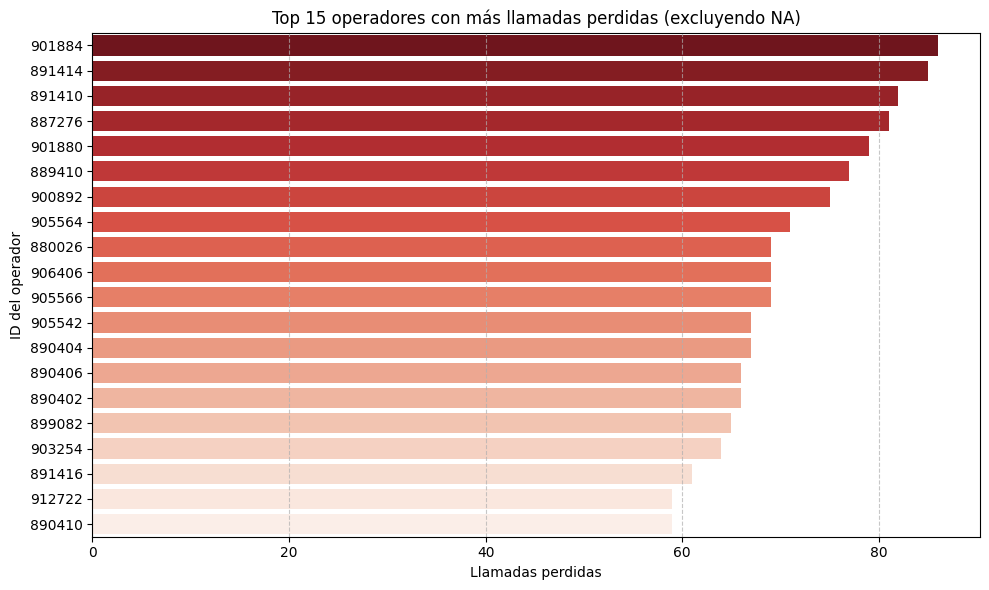

In [391]:
# Filtrar todos los NA como string y como valor faltante
operadores_real = operator_perf[
    operator_perf['operator_id'].notna() & 
    (~operator_perf['operator_id'].isin(['nan', '<NA>']))
]

# Gráfico actualizado
top_missed_real = operadores_real.sort_values(by='missed_calls', ascending=False).head(20)

plt.figure(figsize=(10,6))
sns.barplot(data=top_missed_real, x='missed_calls', y='operator_id', palette='Reds_r')
plt.title('Top 15 operadores con más llamadas perdidas (excluyendo NA)')
plt.xlabel('Llamadas perdidas')
plt.ylabel('ID del operador')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

El gráfico revela que los 20 operadores con más llamadas perdidas concentran un volumen sustancial de ineficiencia operativa. Este grupo representa una oportunidad clara de mejora, ya sea mediante capacitación específica, redistribución de carga o revisión de condiciones técnicas.

C:\Users\joako\AppData\Local\Temp\ipykernel_18300\2735245217.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_top_wait, x='operator_id', y='wait_time', palette='coolwarm')


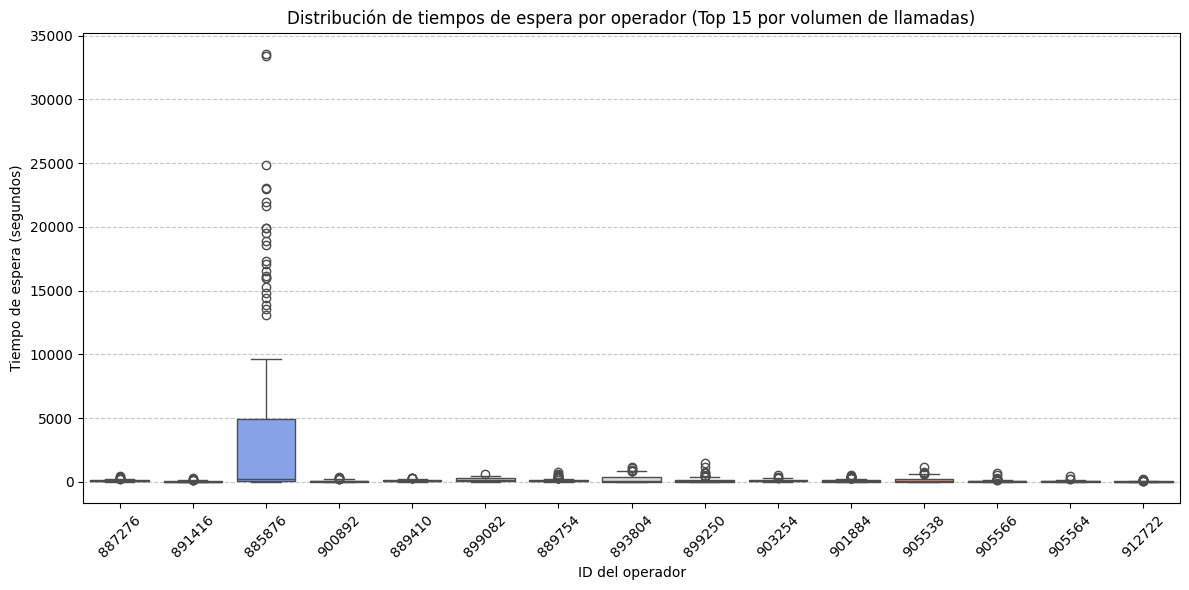

In [392]:
# Opcional: filtrar a operadores con mayor número de llamadas
top_operators = df_calls_no_outliers['operator_id'].value_counts().head(15).index
df_top_wait = df_calls_no_outliers[df_calls_no_outliers['operator_id'].isin(top_operators)]

# Crear el boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_top_wait, x='operator_id', y='wait_time', palette='coolwarm')
plt.title('Distribución de tiempos de espera por operador (Top 15 por volumen de llamadas)')
plt.xlabel('ID del operador')
plt.ylabel('Tiempo de espera (segundos)')
plt.xticks(rotation=45)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

El boxplot muestra que, aunque existe un caso extremo (operador 885876) con tiempos de espera altamente elevados y múltiples outliers, la mayoría de los operadores del top 15 mantienen tiempos de espera relativamente bajos y consistentes. Este hallazgo confirma que, en términos generales, el tiempo de espera no es un problema estructural grave, sino más bien un área puntual de mejora para ciertos operadores específicos.

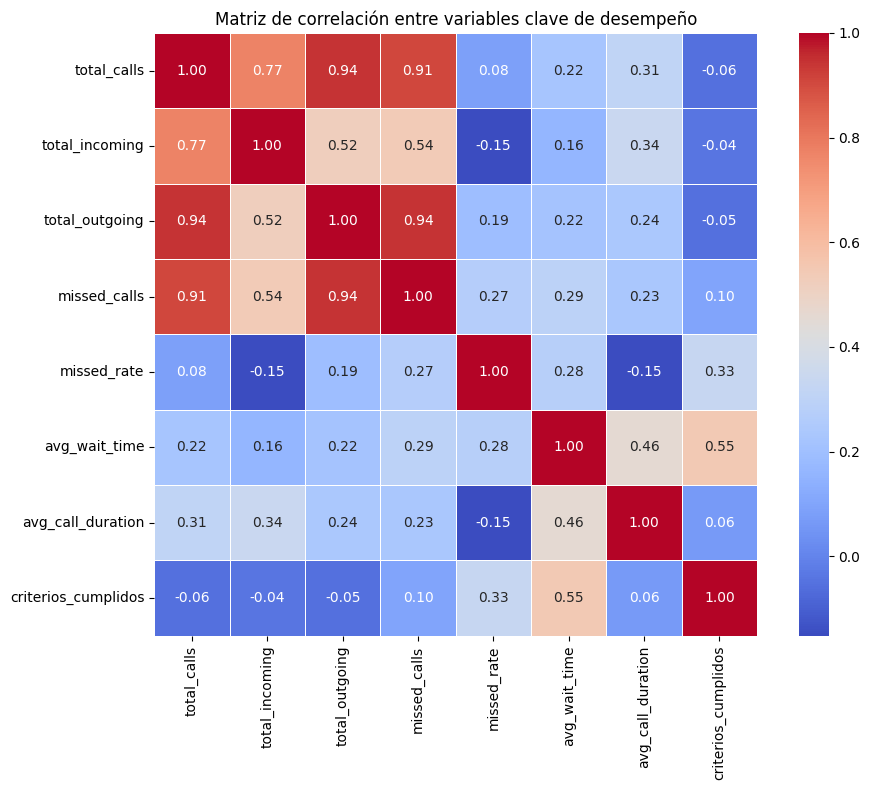

In [393]:
# Seleccionar solo columnas numéricas relevantes
cols_corr = [
    'total_calls', 'total_incoming', 'total_outgoing',
    'missed_calls', 'missed_rate', 
    'avg_wait_time', 'avg_call_duration',
    'criterios_cumplidos'
]

# Crear matriz de correlación
corr_matrix = operator_perf[cols_corr].corr()

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, square=True)
plt.title('Matriz de correlación entre variables clave de desempeño')
plt.tight_layout()
plt.show()

El heatmap evidencia que la principal raíz de la ineficiencia está en la distribución desigual de carga operativa, más allá de factores individuales como la antigüedad o el plan tarifario. Esto respalda decisiones orientadas a la redistribución de llamadas, refuerzo en picos de carga y optimización del flujo de atención, especialmente para operadores con alto volumen.

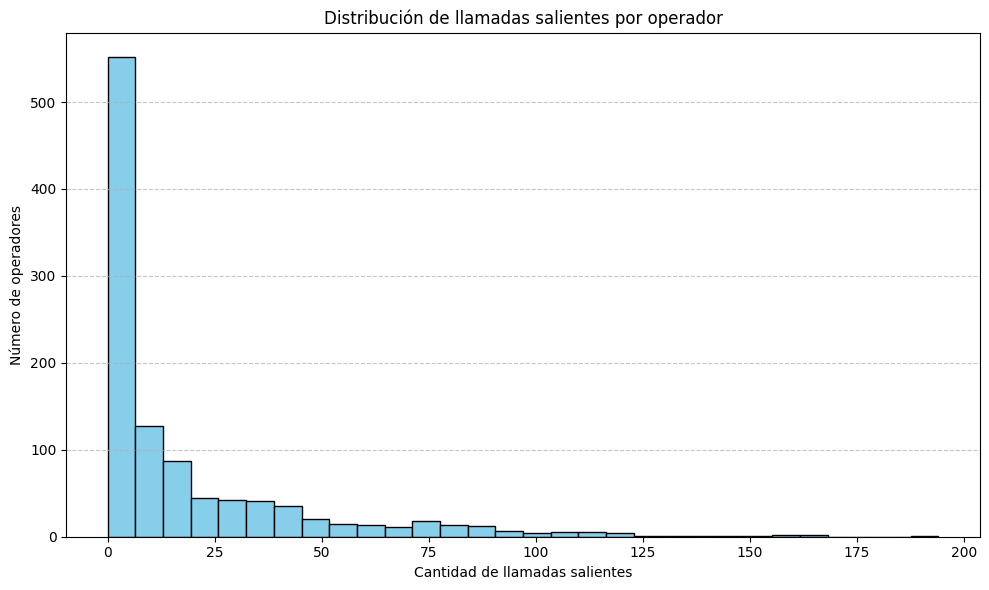

In [394]:
plt.figure(figsize=(10,6))
plt.hist(operator_perf['total_outgoing'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribución de llamadas salientes por operador')
plt.xlabel('Cantidad de llamadas salientes')
plt.ylabel('Número de operadores')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

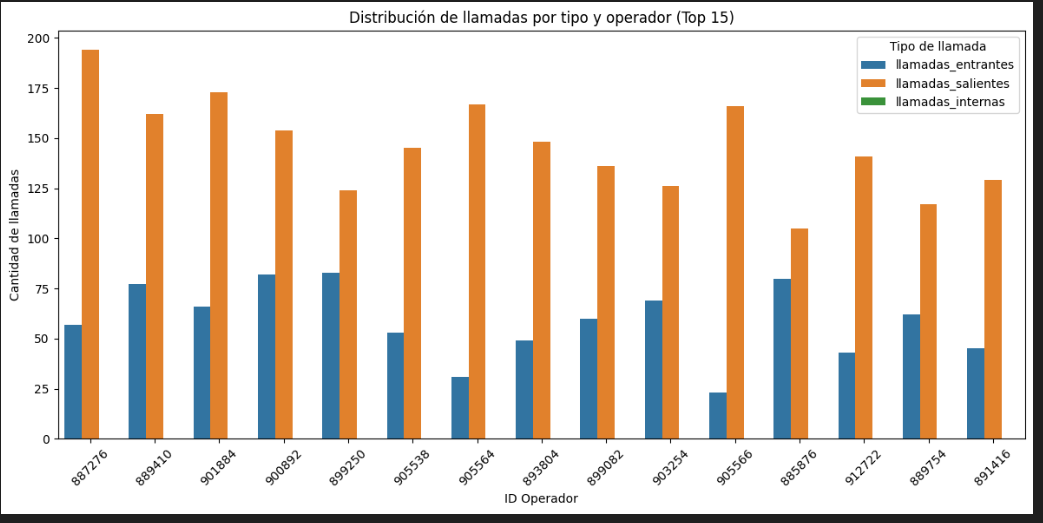  

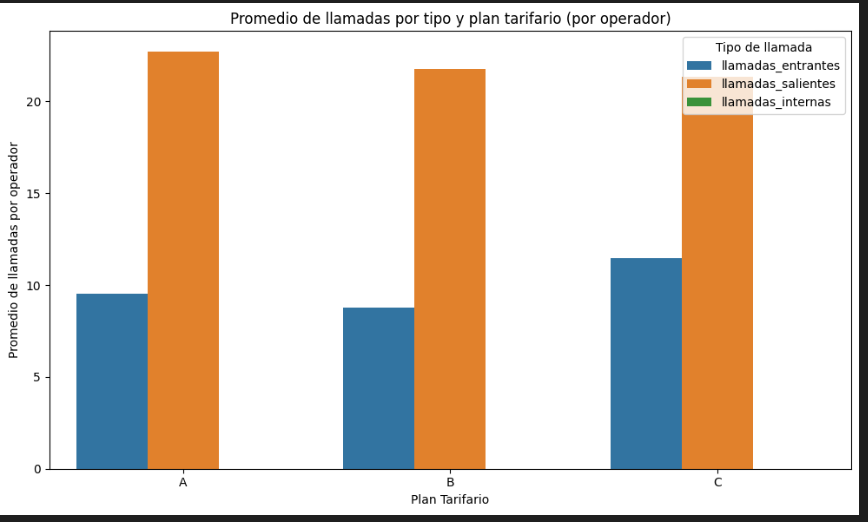

Llamadas salientes: distribución, comportamiento por operador y plan tarifario
El análisis de llamadas salientes reveló que:

Distribución sesgada (histograma):
Una gran proporción de operadores realizan pocas o ninguna llamada saliente, mientras que un grupo mucho más reducido concentra el mayor volumen. Este comportamiento indica una desigualdad operativa significativa en la ejecución de este tipo de llamadas.

Top operadores (gráfico por tipo de llamada):
Incluso entre los operadores con mayor carga operativa, las llamadas salientes superan ampliamente a las entrantes. Esto confirma que las llamadas salientes son el tipo de interacción predominante en la plataforma, y por tanto, un eje central en la operación del servicio.

Promedio por plan tarifario:
Los tres planes presentan un patrón similar: las llamadas salientes representan la mayoría de las interacciones por operador, sin importar el plan. No obstante, la cantidad de llamadas entrantes es más alta en el plan C, lo que podría estar ligado a un perfil de cliente más activo o exigente.

Recomendación estratégica:
Dado que las llamadas salientes constituyen el grueso de la operación, y una gran cantidad de operadores no participa activamente en este tipo de contacto, se sugiere establecer incentivos directos o indirectos que promuevan su realización. Esto podría equilibrar la carga entre operadores, mejorar la atención al cliente proactiva y reducir la presión en los equipos de soporte reactivo (llamadas entrantes).



### Tablas de clasificación:




In [395]:
# Ordenar por número de criterios cumplidos (más ineficiente arriba), luego por tasa de pérdida y espera
ranking_final = operator_perf.sort_values(
    by=['criterios_cumplidos', 'missed_rate', 'avg_wait_time'],
    ascending=False
)

# Seleccionar columnas clave para mostrar
ranking_cols = [
    'operator_id', 'criterios_cumplidos', 'missed_rate', 'avg_wait_time',
    'total_calls', 'total_incoming', 'total_outgoing',
    'ineficiente_missed', 'ineficiente_wait', 'ineficiente_outgoing'
]

# Mostrar top 20
ranking_final[ranking_cols].head(20)

,operator_id,criterios_cumplidos,missed_rate,avg_wait_time,total_calls,total_incoming,total_outgoing,ineficiente_missed,ineficiente_wait,ineficiente_outgoing
435,919202,2,1.000000,265.000000,1,0,1,True,True,False
1061,972410,2,1.000000,224.000000,1,0,1,True,True,False
838,945320,2,1.000000,196.666667,3,0,3,True,True,False
1026,965540,2,1.000000,131.000000,2,0,2,True,True,False
832,945308,2,1.000000,126.000000,2,0,2,True,True,False
323,909308,2,1.000000,116.333333,3,0,3,True,True,False
829,945296,2,0.875000,178.125000,8,0,8,True,True,False
213,902742,2,0.850000,140.150000,20,0,20,True,True,False
834,945312,2,0.833333,238.500000,6,0,6,True,True,False
151,898434,2,0.833333,66.833333,6,0,6,True,True,False


Ranking de operadores según su desempeño
La tabla presentada muestra el ranking de los operadores con peor desempeño según un sistema de clasificación basado en tres criterios clave de ineficiencia:

Alta tasa de llamadas perdidas (missed_rate)

Altos tiempos promedio de espera (avg_wait_time)

Baja proporción de llamadas salientes (si aplica)

Cada operador fue evaluado individualmente y recibió una calificación entre 0 y 3 criterios cumplidos, representando el número de dimensiones en las que muestra comportamientos ineficientes. A mayor número de criterios cumplidos, mayor prioridad para intervención o mejora.


 Cómo utilizar esta tabla (para supervisores y supervisoras):
Identificación directa de operadores prioritarios:
Los operadores en los primeros lugares del ranking representan los casos más urgentes. Supervisores pueden revisar con ellos los motivos detrás del mal desempeño y tomar acciones correctivas.

Focalización de estrategias de capacitación o redistribución:
Al identificar operadores que sistemáticamente incumplen en más de un criterio, se pueden dirigir recursos de formación, acompañamiento o ajustes de carga de trabajo más eficientemente.

Monitoreo continuo del impacto de intervenciones:
Esta tabla puede actualizarse periódicamente para verificar si las acciones implementadas mejoran los indicadores clave por operador.

Ejemplo de uso práctico:
“El operador 919202 muestra una tasa de pérdida del 100%, un tiempo promedio de espera de 265 segundos, y no realiza llamadas salientes. Cumple 2 de los 3 criterios de ineficiencia. Esto lo convierte en un claro candidato para revisión inmediata por parte del equipo de supervisión.”

In [396]:
# Agrupar operadores por plan tarifario y calcular métricas clave
tabla_tarifas = operator_perf.groupby('tariff_plan').agg(
    operadores_totales=('operator_id', 'nunique'),
    ineficientes=('es_ineficiente', 'sum'),
    prop_ineficientes=('es_ineficiente', 'mean'),
    missed_rate_promedio=('missed_rate', 'mean'),
    wait_time_promedio=('avg_wait_time', 'mean'),
    criterios_promedio=('criterios_cumplidos', 'mean')
).reset_index()

# Ordenar por proporción de ineficiencia si se desea
tabla_tarifas.sort_values(by='prop_ineficientes', ascending=False, inplace=True)

# Mostrar tabla
tabla_tarifas

,tariff_plan,operadores_totales,ineficientes,prop_ineficientes,missed_rate_promedio,wait_time_promedio,criterios_promedio
1,B,390,236,0.605128,0.311207,48.468500,0.748718
2,C,384,223,0.580729,0.233633,41.852839,0.703125
0,A,292,152,0.520548,0.294802,53.721009,0.630137


Comparación de desempeño por plan tarifario
Esta tabla agrupa y resume el desempeño de los operadores según el plan tarifario de los clientes que atienden (Planes A, B y C). Se presentan métricas agregadas por cada grupo, lo que permite identificar dónde se concentran los mayores retos operativos.


escripción de columnas:

tariff_plan	Plan tarifario atendido por los operadores.

operadores_totales	Total de operadores que atienden a clientes de ese plan.

ineficientes	Número de operadores marcados como ineficientes en ese plan.

prop_ineficientes	Proporción de operadores ineficientes respecto al total del plan.

missed_rate_promedio	Tasa promedio de llamadas perdidas entre los operadores del plan.

wait_time_promedio	Tiempo promedio de espera de los operadores en ese plan.

criterios_promedio	Promedio de criterios de ineficiencia cumplidos por operador (máx. 3).



El Plan B tiene la mayor proporción de operadores ineficientes (60.6%), lo que sugiere una posible sobrecarga operativa o falta de adecuación en la atención.

El Plan C tiene una proporción similar (57.8%) pero muestra mejores indicadores promedio en llamadas perdidas y tiempos de espera.

El Plan A, aunque con menor proporción de ineficiencia, presenta el tiempo de espera promedio más alto (53.7s), lo que sugiere problemas puntuales de flujo o distribución interna.

Cómo pueden usarla los supervisores:
Asignación más eficiente de operadores:
Redistribuir personal o reforzar los planes más críticos (B y C), especialmente donde hay alto volumen de clientes.

Diseño de planes de mejora específicos por tarifa:
En lugar de acciones generales, esta tabla permite definir estrategias adaptadas al comportamiento de cada plan, optimizando recursos.

Seguimiento mensual por plan:
Esta tabla sirve como base para construir un monitoreo continuo, donde los supervisores puedan identificar si las mejoras están teniendo efecto en cada segmento.

## Conclusiones y Recomendaciones

### Objetivo
Identificar a los operadores menos eficientes de la plataforma CallMeMaybe, entender los factores que afectan el desempeño y proporcionar recomendaciones accionables para mejorar la experiencia del cliente y la eficiencia del servicio



### Factores que afectan el desempeño
A partir del análisis de más de 1,000 operadores, se identificaron tres principales factores de ineficiencia:

Carga de trabajo desbalanceada
Operadores con más llamadas entrantes tienden a tener una mayor tasa de llamadas perdidas, confirmando que la sobrecarga operativa afecta directamente la eficiencia. Esto se acentuó en el plan B, que presenta la mayor proporción de operadores ineficientes (60.6%).

Tiempos de espera excesivos en casos aislados
Aunque la mayoría de los operadores mantienen tiempos razonables, algunos casos extremos afectan la percepción del servicio. Un operador presentó tiempos superiores a 30,000 segundos en llamadas individuales.

Llamadas sin operador asignado
Se detectó un volumen considerable (más de 6,000 llamadas) sin asignación de operator_id, lo que sugiere vacíos operativos graves posiblemente relacionados con horarios sin cobertura.

### Conclusiones
La eficiencia no está determinada por la antigüedad del cliente ni por el plan tarifario de forma aislada, sino por una combinación de volumen de llamadas, tipo de interacción y carga del operador.

El 57.3% de los operadores fueron clasificados como ineficientes al menos en dos de los tres criterios definidos.

Los operadores más ineficientes concentran altos tiempos de espera y altas tasas de pérdida, lo que puede deteriorar la experiencia del cliente significativamente.

### Respuestas clave
#### ¿Es necesario redistribuir las llamadas?
Sí.
La fuerte correlación entre carga de llamadas entrantes y tasa de llamadas perdidas sugiere que una redistribución equilibrada del flujo de llamadas podría reducir drásticamente la pérdida de contactos.

#### ¿Se requieren más operadores en ciertas franjas horarias?
Sí.
La gran cantidad de llamadas sin operador asignado indica vacíos operativos, posiblemente en horarios de baja cobertura. Se recomienda evaluar la apertura de un centro de atención en zonas horarias complementarias (e.g., Bangladesh) para asegurar atención 24/7.

#### ¿Algunos planes tarifarios afectan negativamente el rendimiento?
Sí, pero cada uno lo hace de forma distinta y relevante.

Plan A:

Aunque tiene la menor cantidad de operadores, es el plan que recibe más llamadas en promedio por operador y presenta las tasas de pérdida más altas. También muestra una mayor dispersión en el rendimiento, lo que indica que algunos operadores pueden estar sobrepasados o que hay falta de estandarización en los procesos.

Plan B:

Es el plan con la mayor proporción de operadores ineficientes (60.6%). Si bien la tasa de pérdida y el tiempo de espera promedio no son los peores, la cantidad de operadores ineficientes sugiere problemas generalizados de gestión operativa, como falta de seguimiento, capacitación o estructura.

Plan C:

Presenta los mejores indicadores operativos en promedio (menor missed_rate y menor wait_time). Sin embargo, tiene más clientes que operadores, lo que podría poner en riesgo su buen desempeño a futuro si no se corrige el desbalance. A pesar de sus buenos promedios, más del 57% de sus operadores fueron clasificados como ineficientes.

### Recomendaciones finales

Implementar un sistema inteligente de distribución de llamadas para balancear la carga operativa entre operadores.

Establecer incentivos específicos para llamadas salientes, que representan el mayor volumen, pero no son realizadas por muchos operadores.

Investigar causas operativas de llamadas sin asignación y establecer coberturas estratégicas en horarios críticos.

Desarrollar dashboards periódicos de monitoreo por operador y plan tarifario, permitiendo seguimiento constante y toma de decisiones basada en datos.

Revisar el desempeño de los 25 operadores con peor ranking, priorizando intervenciones correctivas personalizadas (formación, redistribución o rotación).